In [1]:
import warnings
import json
import datetime
import functools as fn
import collections as cc
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, ShuffleSplit, KFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

%matplotlib inline
pd.set_option('display.max_columns', 250)
warnings.filterwarnings('ignore')

In [2]:
train_features = pd.read_csv('./train_features.csv')
train_targets = pd.read_csv('./train_targets.csv')
test_features = pd.read_csv('./test_features.csv')

In [3]:
train_targets.shape, train_features.shape 

((39675, 6), (39675, 246))

In [4]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39675 entries, 0 to 39674
Columns: 246 entries, match_id_hash to d5_sen_placed
dtypes: float64(30), int64(215), object(1)
memory usage: 74.5+ MB


In [5]:
train_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39675 entries, 0 to 39674
Data columns (total 6 columns):
match_id_hash       39675 non-null object
game_time           39675 non-null int64
radiant_win         39675 non-null bool
duration            39675 non-null int64
time_remaining      39675 non-null int64
next_roshan_team    25325 non-null object
dtypes: bool(1), int64(3), object(2)
memory usage: 1.6+ MB


## Numbers of matches 

In [6]:
train_features['match_id_hash'].nunique()

39675

In [7]:
train_targets.head()

match_id_hash  game_time  radiant_win  duration  \
0  a400b8f29dece5f4d266f49f1ae2e98a        155        False       992   
1  b9c57c450ce74a2af79c9ce96fac144d        658         True      1154   
2  6db558535151ea18ca70a6892197db41         21         True      1503   
3  46a0ddce8f7ed2a8d9bd5edcbb925682        576         True      1952   
4  b1b35ff97723d9b7ade1c9c3cf48f770        453        False      2001   

   time_remaining next_roshan_team  
0             837              NaN  
1             496              NaN  
2            1482          Radiant  
3            1376              NaN  
4            1548              NaN

In [8]:
train_features.head()

match_id_hash  game_time  game_mode  lobby_type  \
0  a400b8f29dece5f4d266f49f1ae2e98a        155         22           7   
1  b9c57c450ce74a2af79c9ce96fac144d        658          4           0   
2  6db558535151ea18ca70a6892197db41         21         23           0   
3  46a0ddce8f7ed2a8d9bd5edcbb925682        576         22           7   
4  b1b35ff97723d9b7ade1c9c3cf48f770        453         22           7   

   objectives_len  chat_len  r1_hero_id  r1_kills  r1_deaths  r1_assists  \
0               1        11          11         0          0           0   
1               3        10          15         7          2           0   
2               0         0         101         0          0           0   
3               1         4          14         1          0           3   
4               1         3          42         0          1           1   

   r1_denies  r1_gold  r1_lh  r1_xp  r1_health  r1_max_health  r1_max_mana  \
0          0      543      7    533        358            600    350.93784   
1          7     5257     52   3937       1160           1160    566.93805   
2          0      176      0      0        680            680    506.93800   
3          1     1613      0   1471        900            900    290.93777   
4          0     1404      9   1351       1000           1000    338.93784   

   r1_level  r1_x  r1_y  r1_stuns  r1_creeps_stacked  r1_camps_stacked  \
0         2   116   122  0.000000                  0                 0   
1         8    76    78  0.000000                  0                 0   
2         1   118   118  0.000000                  0                 0   
3         4   170    96  2.366089                  0                 0   
4         4    80   164  9.930903                  0                 0   

   r1_rune_pickups  r1_firstblood_claimed  r1_teamfight_participation  \
0                1                      0                    0.000000   
1                0                      0                    0.437500   
2                0                      0                    0.000000   
3                5                      0                    0.571429   
4                4                      0                    0.500000   

   r1_towers_killed  r1_roshans_killed  r1_obs_placed  r1_sen_placed  \
0                 0                  0              0              0   
1                 0                  0              0              0   
2                 0                  0              0              0   
3                 0                  0              0              0   
4                 0                  0              0              0   

   r2_hero_id  r2_kills  r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  \
0          78         0          0           0          3      399      4   
1          96         3          1           2          3     3394     19   
2          51         0          0           0          0      176      0   
3          99         1          0           1          2     2816     30   
4          69         1          0           0          0     1840     14   

   r2_xp  r2_health  r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  \
0    478        636            720    254.93774         2   124   126   
1   3897       1352           1380    386.93787         8    78   166   
2      0        720            720    278.93777         1   156   104   
3   3602        878           1100    494.93796         8    82   154   
4   1693        868           1000    350.93784         5    78   166   

   r2_stuns  r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0  0.000000                  0                 0                0   
1  8.397949                  0                 0                4   
2  0.000000                  0                 0                0   
3  0.000000                  0                 0                1   
4  1.832892                  0                 0                0   

   r2_firstblood_claime

In [9]:
test_features.head()

match_id_hash  game_time  game_mode  lobby_type  \
0  30cc2d778dca82f2edb568ce9b585caa         23          4           0   
1  70e5ba30f367cea48793b9003fab9d38       1044         22           7   
2  4d9ef74d3a2025d79e9423105fd73d41       1091         22           7   
3  2bb79e0c1eaac1608e5a09c8e0c6a555        623         22           7   
4  bec17f099b01d67edc82dfb5ce735a43       1538         22           7   

   objectives_len  chat_len  r1_hero_id  r1_kills  r1_deaths  r1_assists  \
0               0         0          79         0          0           0   
1              12         6          23         3          5           7   
2               6         1          64         3          1           7   
3               1         0          41         0          0           1   
4               7        11          40         2          7          12   

   r1_denies  r1_gold  r1_lh  r1_xp  r1_health  r1_max_health  r1_max_mana  \
0          0      115      0      0        620            620    350.93784   
1          1     5864     27   5629       1440           1440    542.93800   
2          1     4351     16   3909       1060           1060    888.93835   
3          2     2181     23   2284        320            840    338.93784   
4          0     6372     30   7391       1380           1380    734.93820   

   r1_level  r1_x  r1_y   r1_stuns  r1_creeps_stacked  r1_camps_stacked  \
0         1    86   158   0.000000                  0                 0   
1        10   160   154  21.028316                  0                 0   
2         8   134   114   2.932637                  0                 0   
3         5   158    86   0.966406                  0                 0   
4        12   104   138   0.000000                  1                 1   

   r1_rune_pickups  r1_firstblood_claimed  r1_teamfight_participation  \
0                0                      0                    0.000000   
1                1                      1                    0.322581   
2                4                      0                    0.434783   
3                0                      0                    0.200000   
4                8                      0                    1.000000   

   r1_towers_killed  r1_roshans_killed  r1_obs_placed  r1_sen_placed  \
0                 0                  0              1              0   
1                 2                  0              2              0   
2                 1                  0              4              5   
3                 0                  0              0              0   
4                 0                  0              5              0   

   r2_hero_id  r2_kills  r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  \
0          47         0          0           0          0      115      0   
1          12         9          0          10          9     8271     57   
2          62         6          5           8          1     6033      3   
3          50         2          0           2          0     2569     12   
4          98         3          5           3          5    10408    155   

   r2_xp  r2_health  r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  \
0      0        645            660    290.93777         1   172    94   
1   9205       1159           1240    818.93830        14   152    78   
2   4955        207           1190    792.93823         9   164   110   
3   2019        363            720    828.93830         5    82   168   
4  13971       1763           1795   1375.93880        17   122   114   

   r2_stuns  r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0       0.0                  0                 0                1   
1       0.0                  0                 0                4   
2       0.2                  0                 0                7   
3       0.0                  0                 0                6   
4       0.0                  3                 2                6   

   r2_firstblood_

## Radiant win ratio

In [10]:
train_wins = train_targets['radiant_win'].astype('int').value_counts()
train_wins

1    20826
0    18849
Name: radiant_win, dtype: int64

In [11]:
print('Radiant win:')
train_wins[1] / (train_wins[0] + train_wins[1])

Radiant win:


0.5249149338374292

## Kill Roshan and win

In [12]:
roshan_stats = train_targets.loc[:, ['next_roshan_team', 'radiant_win']]
pd.crosstab(roshan_stats['next_roshan_team'], roshan_stats['radiant_win'], margins=True)

radiant_win       False   True    All
next_roshan_team                     
Dire               9275   2860  12135
Radiant            3035  10155  13190
All               12310  13015  25325

## Games mode statistics

In [13]:
train_features['game_mode'].nunique(), test_features['game_mode'].nunique()

(8, 7)

In [14]:
np.sort(train_features['game_mode'].unique()), np.sort(test_features['game_mode'].unique())

(array([ 2,  3,  4,  5, 12, 16, 22, 23]), array([ 2,  3,  4,  5, 12, 22, 23]))

In [15]:
train_features.loc[:, ['game_mode', 'match_id_hash']].groupby(by=['game_mode']).count()

match_id_hash
game_mode               
2                    408
3                   1200
4                   3564
5                    188
12                     5
16                     2
22                 31762
23                  2546

In [16]:
test_features.loc[:, ['game_mode', 'match_id_hash']].groupby(by=['game_mode']).count()

match_id_hash
game_mode               
2                     34
3                    337
4                    680
5                     28
12                     3
22                  8289
23                   629

## Lobby type statistics

In [17]:
train_features['lobby_type'].nunique(), test_features['lobby_type'].nunique()

(2, 2)

In [18]:
train_features.loc[:, ['lobby_type', 'match_id_hash']].groupby(by=['lobby_type']).count()

match_id_hash
lobby_type               
0                   12626
7                   27049

In [19]:
test_features.loc[:, ['lobby_type', 'match_id_hash']].groupby(by=['lobby_type']).count()

match_id_hash
lobby_type               
0                    3088
7                    6912

## Unique heroes

In [20]:
heroes_columns = ['r{}_hero_id'.format(i) for i in range(1, 6)] + ['d{}_hero_id'.format(i) for i in range(1, 6)] 
heroes_in_train = set(train_features.loc[:, heroes_columns].values.flatten())
heroes_in_test = set(test_features.loc[:, heroes_columns].values.flatten())
print(len(heroes_in_train), len(heroes_in_test), heroes_in_test == heroes_in_train)

115 115 True


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]),
 <a list of 115 Text xticklabel objects>)

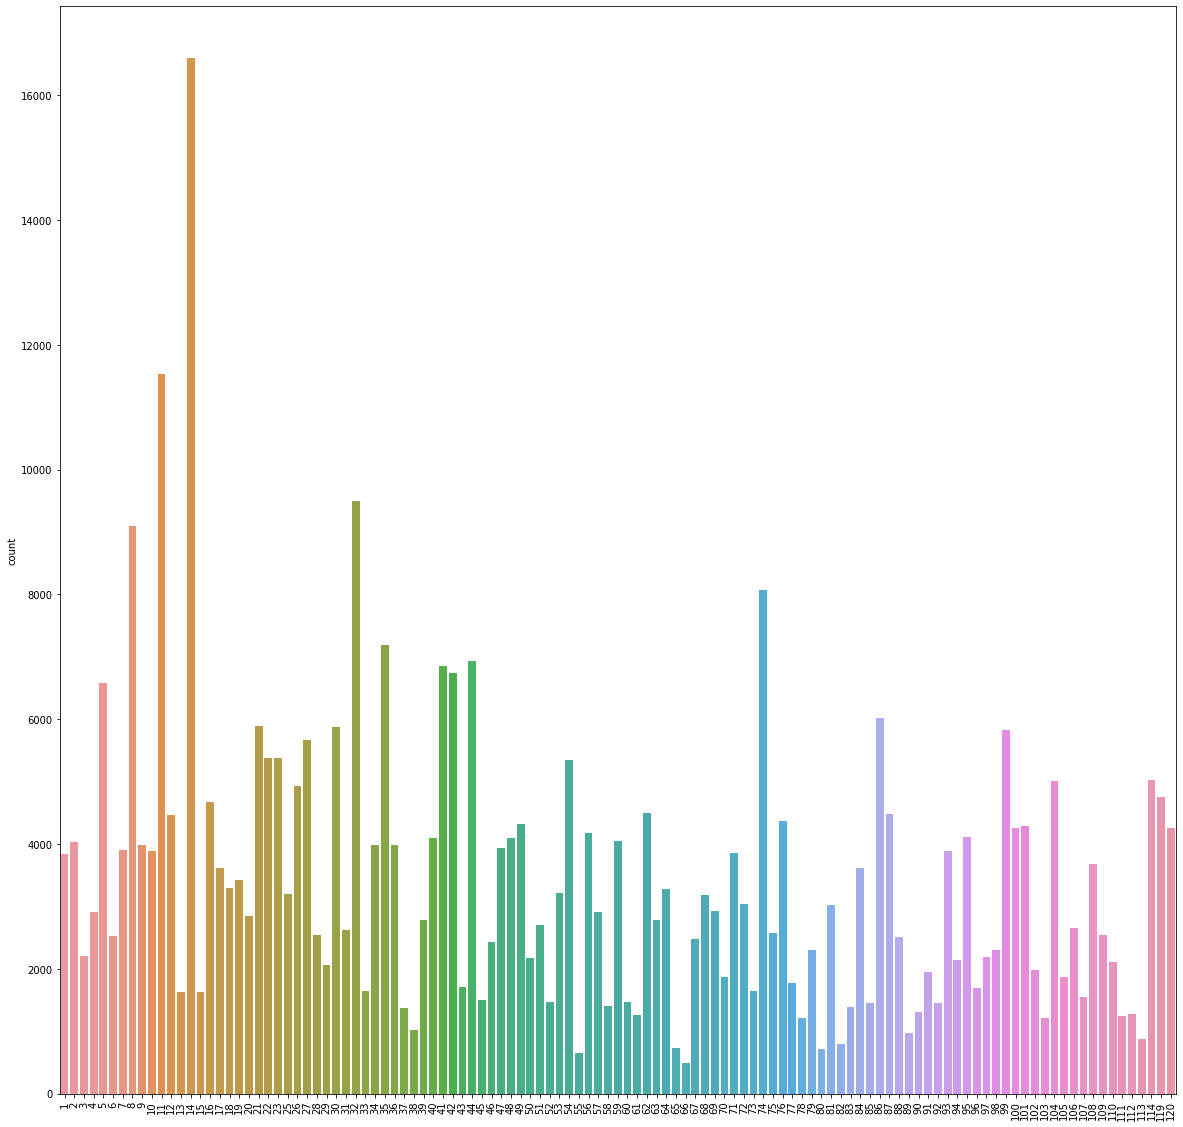

In [21]:
plt.figure(figsize=(20, 20))
sns.countplot(train_features.loc[:, heroes_columns].values.flatten())
plt.xticks(rotation=90)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]),
 <a list of 115 Text xticklabel objects>)

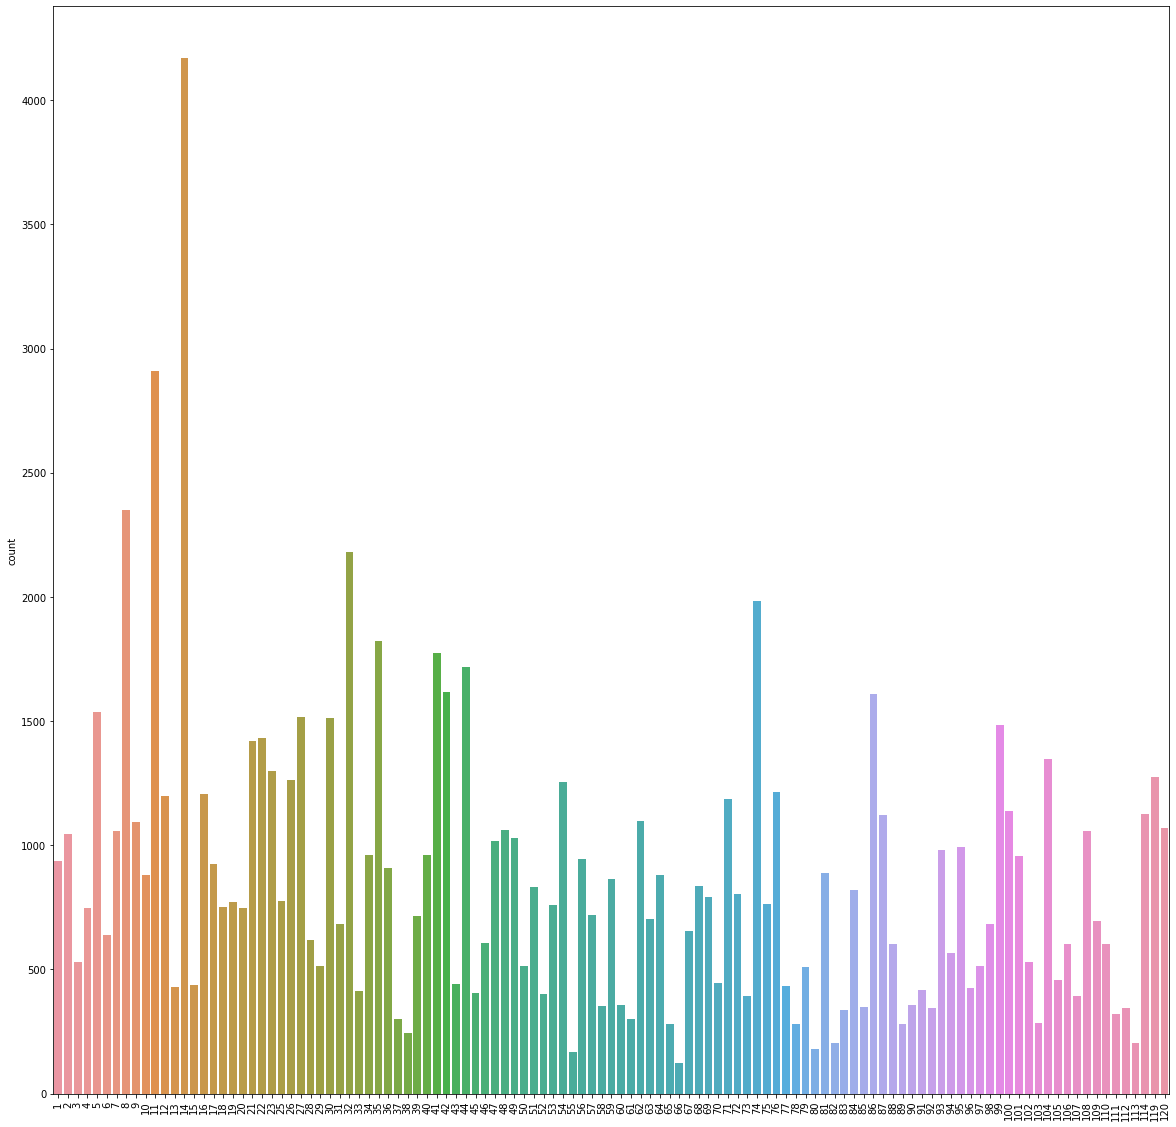

In [22]:
plt.figure(figsize=(20, 20))
sns.countplot(test_features.loc[:, heroes_columns].values.flatten())
plt.xticks(rotation=90)

## Chat statistics 

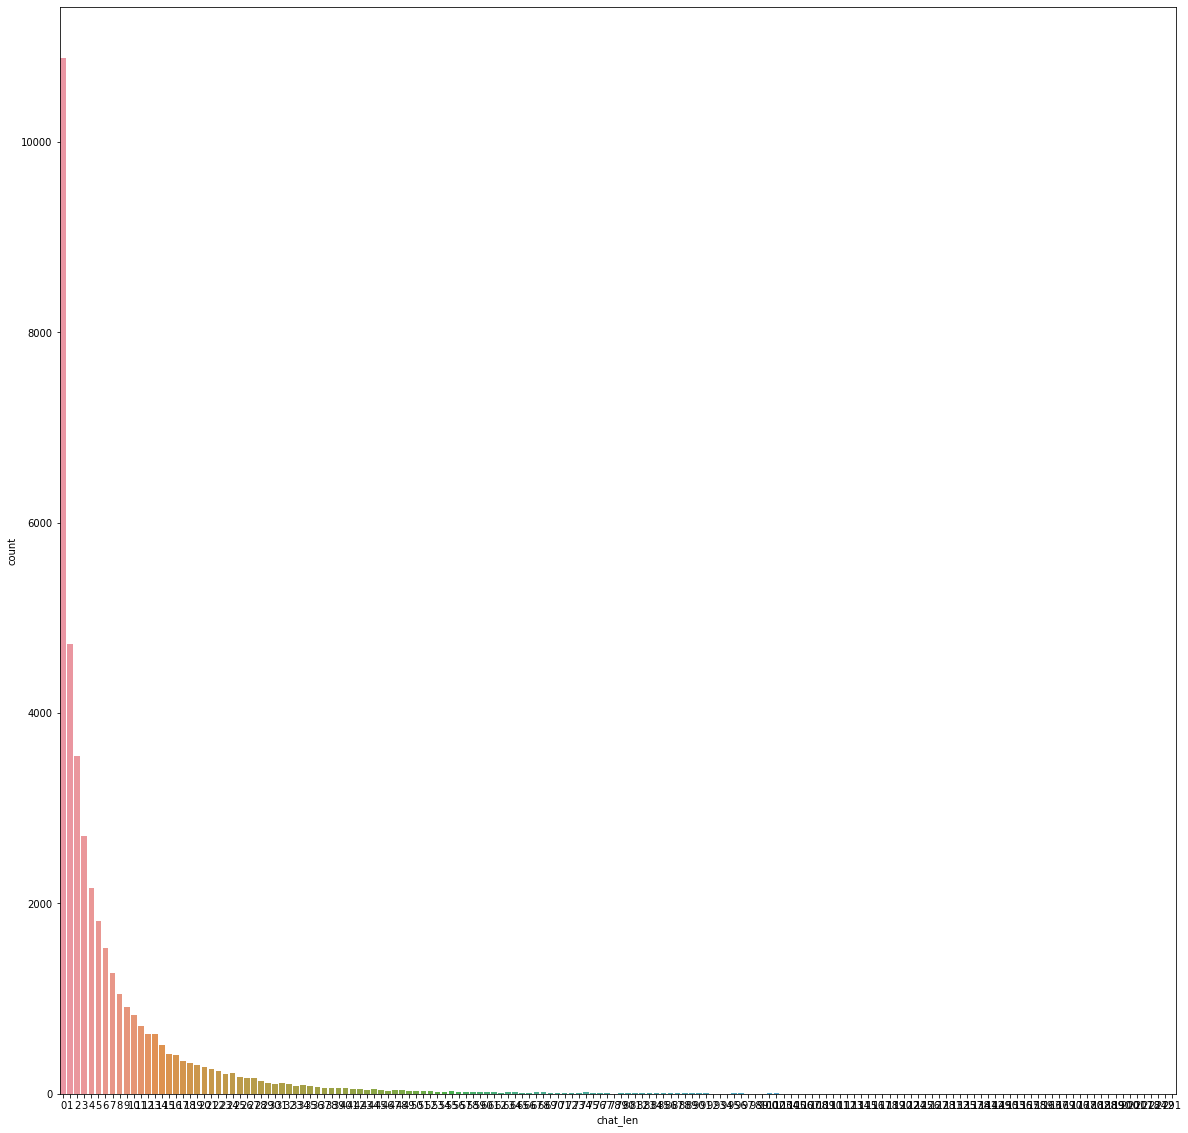

In [23]:
plt.figure(figsize=(20,20))
sns.countplot(train_features['chat_len'])

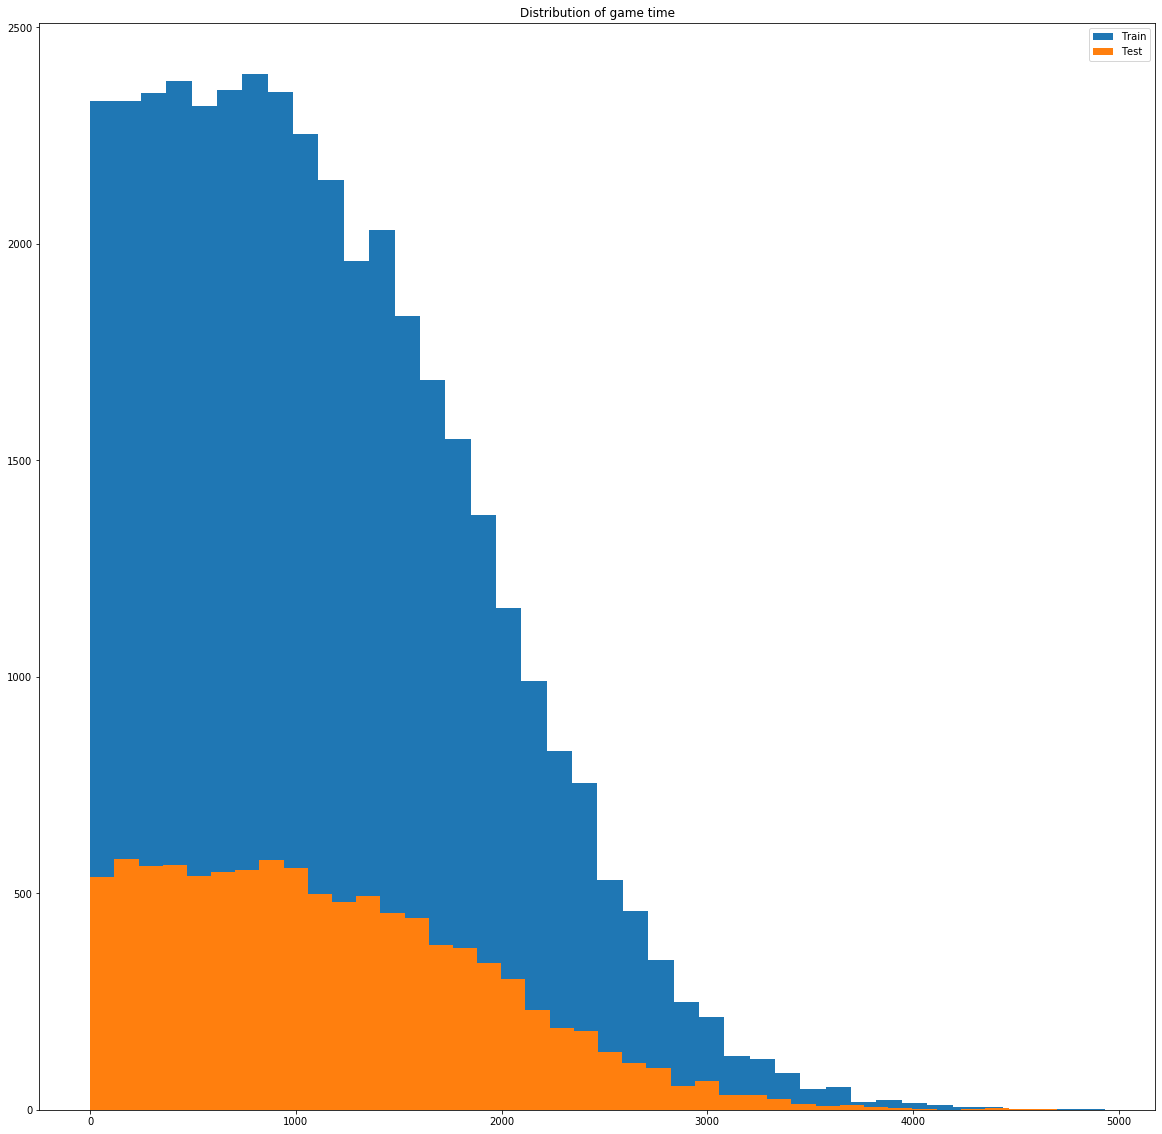

In [24]:
plt.figure(figsize=(20, 20))
plt.hist(train_features['game_time'], bins=40, label='Train');
plt.hist(test_features['game_time'], bins=40, label='Test');
plt.title('Distribution of game time');
plt.legend();

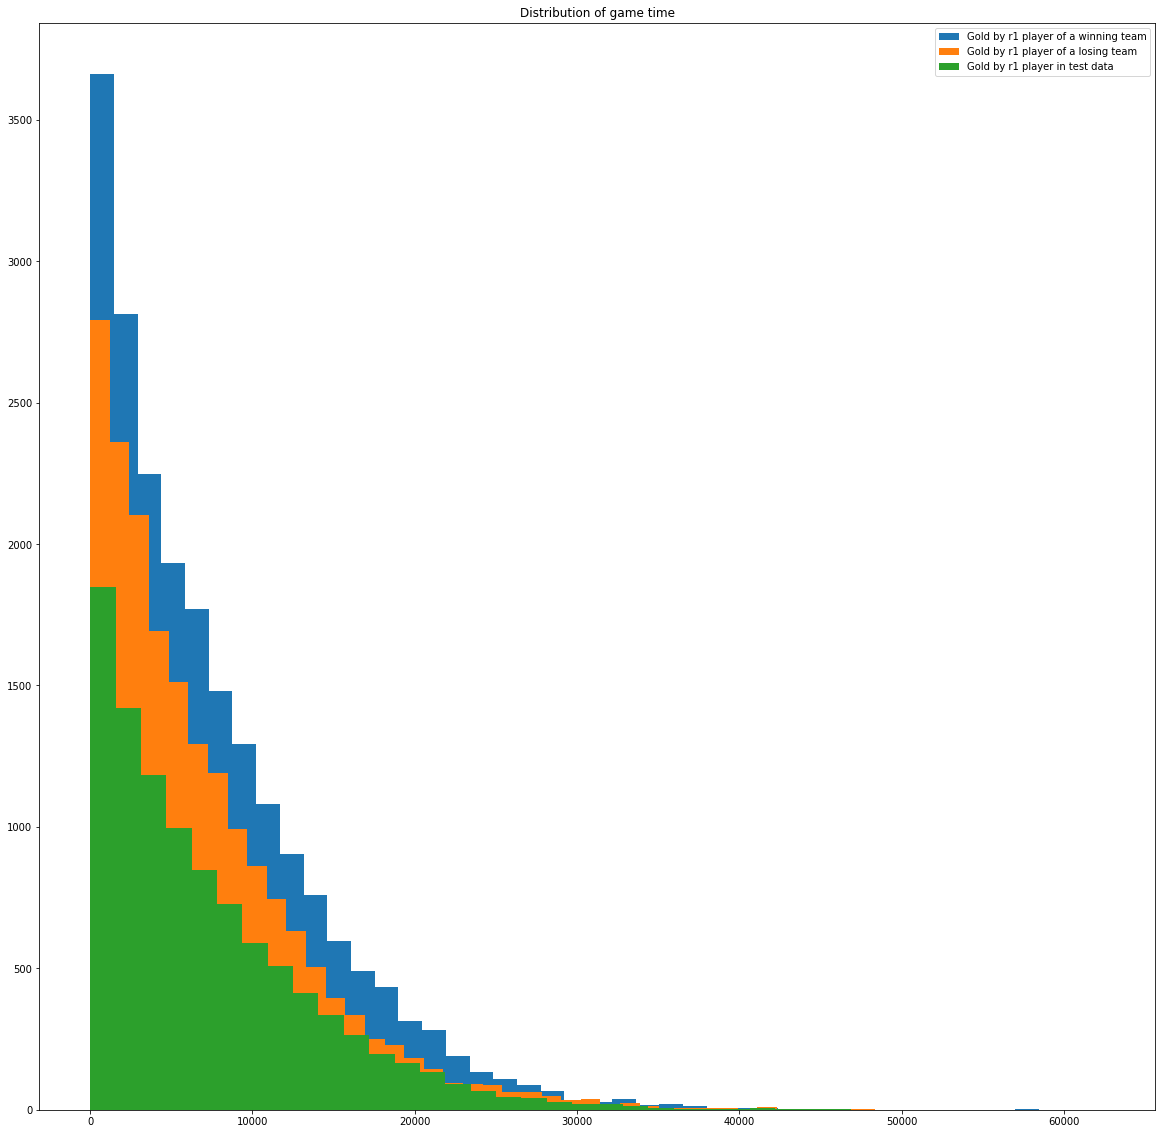

In [25]:
plt.figure(figsize=(20, 20))
plt.hist(train_features.loc[train_targets['radiant_win'] == True, 'r1_gold'], bins=40, label='Gold by r1 player of a winning team');
plt.hist(train_features.loc[train_targets['radiant_win'] == False, 'r1_gold'], bins=40, label='Gold by r1 player of a losing team');
plt.hist(test_features['r1_gold'], bins=40, label='Gold by r1 player in test data');
plt.title('Distribution of game time');
plt.legend();

## Prepare data: delete 'match_id_hash' and make 'y' column 

In [3]:
X_train = train_features.iloc[:, 1:]
y_train = train_targets['radiant_win'].astype('int')
X_test = test_features.iloc[:, 1:]

## All model functions

In [4]:
def complex_holdout_score(y, prediction):
    a_score = accuracy_score(y, prediction > 0.5)
    ra_score = roc_auc_score(y, prediction)
    print('Accuracy score(holdout): ', str(a_score))
    print('ROC AUC score(holdout): ', str(ra_score))
    return {'Accuracy': a_score, 'ROC AUC': ra_score}


def complex_cv_score(cv_score):
    cv_mean = cv_score.mean()
    cv_std = cv_score.std()
    print('ROC AUC mean score(cv): ', str(cv_mean))
    print('ROC AUC score std(cv): ', str(cv_std))
    return cv_mean, cv_std


def compare_cv_scores(score_1, score_2):
    return score_2 > score_1

## Model coefficients

In [5]:
def get_coefficients(model, model_type, data):
    coefs = None
    if model_type == 'lr':
        coefs = pd.DataFrame(model.coef_.T, data.columns)
        coefs.columns = ["coef"]
        coefs["abs"] = coefs.coef.apply(np.abs)
        coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)    
    if model_type == 'cb':
        coefs = pd.DataFrame({'feature_name': data.columns, 'importance': model.feature_importances_})
        coefs.sort_values(by=['importance'], inplace=True, ascending=False)
    
    return coefs

## Unique model 'mentor'

In [6]:
def model_encoder(code):
    if code == 'lr':
        return 'logistic regression(sklearn)'
    elif code == 'rf':
        return 'random forest(sklearn)'
    elif code == 'cb':
        return 'gradient boosting(Catboost)'
    
    
def train_model(X, y, model_type='lr', params={}, test_size=0.3, cv=None, model=None, gs=False, gs_params={}, random_state=1):
    print('Selected model type: {}'.format(model_encoder(model_type)))
    
    if cv == None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    if gs:
        pass
    
    cv_score = None
    cv_mean = None
    holdout_score = None
    coefs = 0
    if model_type == 'lr':
        model = LogisticRegression(random_state=random_state, solver='liblinear', **params)
        model.fit(X_train, y_train)
        prediction = model.predict_proba(X_valid)[:, 1]
        holdout_score = complex_holdout_score(y_valid, prediction)
        cv_score = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
        cv_mean, cv_std = complex_cv_score(cv_score)
        coefs = get_coefficients(model, model_type, X_train)
    if model_type == 'cb':
        model = CatBoostClassifier(random_seed=random_state, silent=True, **params)
        model.fit(X_train, y_train);
        prediction = model.predict_proba(X_valid)[:, 1]
        holdout_score = complex_holdout_score(y_valid, prediction)
        cv_score = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
        cv_mean, cv_std = complex_cv_score(cv_score)
        coefs = get_coefficients(model, model_type, X_train)
    
    return holdout_score, cv_score, coefs

In [30]:
%%time
def_lr_holdout_score, def_lr_cv_score, def_lr_coefs = train_model(X_train, y_train, model_type='lr')
def_lr_coefs.head(30)

Selected model type: logistic regression(sklearn)
Accuracy score(holdout):  0.7234310677980341
ROC AUC score(holdout):  0.8100382379210506
ROC AUC mean score(cv):  0.8130515158008503
ROC AUC score std(cv):  0.0020280530577245714
CPU times: user 1min 16s, sys: 232 ms, total: 1min 17s
Wall time: 5min 9s


coef
d5_level                   -0.138622
r4_level                    0.133564
d2_level                   -0.132416
r5_level                    0.127110
r1_level                    0.121746
r3_level                    0.114877
d3_level                   -0.113961
d4_level                   -0.113818
d2_towers_killed           -0.104599
d1_level                   -0.104573
r2_level                    0.095214
r4_towers_killed            0.091880
r1_towers_killed            0.078525
r3_towers_killed            0.068399
r4_teamfight_participation  0.067408
r4_firstblood_claimed       0.066839
d2_teamfight_participation -0.062058
d3_towers_killed           -0.055831
d2_camps_stacked            0.054944
r1_teamfight_participation  0.049324
d1_firstblood_claimed      -0.047977
d3_teamfight_participation -0.044543
d1_towers_killed           -0.043332
d4_towers_killed           -0.040530
r5_towers_killed            0.040409
r5_firstblood_claimed      -0.034954
d5_teamfight_participation -0.034524
r2_towers_killed            0.034345
d5_towers_killed           -0.034228
d2_obs_placed              -0.033670

In [31]:
%%time
cat_params = {
    'cat_features': [1, 2]
}

def_cb_holdout_score, def_cb_cv_score, def_cb_coefs = train_model(X_train, y_train, model_type='cb', params=cat_params)
def_cb_coefs.head(30)

Selected model type: gradient boosting(Catboost)
Accuracy score(holdout):  0.7157859363185751
ROC AUC score(holdout):  0.8012728326313402
ROC AUC mean score(cv):  0.8064434003524685
ROC AUC score std(cv):  0.001601002422198521
CPU times: user 3min 22s, sys: 7.68 s, total: 3min 30s
Wall time: 2min 31s


feature_name  importance
199    d4_deaths    1.408951
79     r4_deaths    1.378680
226      d5_gold    1.371402
103    r5_deaths    1.348605
130      d1_gold    1.291806
151    d2_deaths    1.179579
178      d3_gold    1.167408
7      r1_deaths    1.163646
34       r2_gold    1.135285
41          r2_x    1.080168
33     r2_denies    1.076939
131        d1_lh    1.057452
175    d3_deaths    1.023350
137         d1_x    1.019254
18          r1_y    0.998500
42          r2_y    0.997216
154      d2_gold    0.984423
223    d5_deaths    0.978736
58       r3_gold    0.978687
10       r1_gold    0.959337
181    d3_health    0.955724
17          r1_x    0.945254
82       r4_gold    0.944809
161         d2_x    0.930631
202      d4_gold    0.916393
210         d4_y    0.915954
203        d4_lh    0.906475
185         d3_x    0.903341
162         d2_y    0.896118
153    d2_denies    0.892062

## Check winrate for heroes

In [7]:
UNIQUE_HEROES = 115
win_matrix = np.zeros((UNIQUE_HEROES, UNIQUE_HEROES))
loss_matrix = np.zeros((UNIQUE_HEROES, UNIQUE_HEROES))

In [8]:
heroes_columns = ['r{}_hero_id'.format(i) for i in range(1, 6)] + ['d{}_hero_id'.format(i) for i in range(1, 6)] 
heroes_df = train_features.loc[:, heroes_columns]
heroes_df['target'] = train_targets['radiant_win'].astype('int')
heroes_df.head()

r1_hero_id  r2_hero_id  r3_hero_id  r4_hero_id  r5_hero_id  d1_hero_id  \
0          11          78          14          59          77          12   
1          15          96          27          63          89          58   
2         101          51          44          49          53          18   
3          14          99         101          26          41          18   
4          42          69          27         104          65          23   

   d2_hero_id  d3_hero_id  d4_hero_id  d5_hero_id  target  
0          21          60          84          34       0  
1          14           1          56          92       1  
2          67          47          40          17       1  
3          98           8          69          86       1  
4          22          35          72           1       0

In [9]:
unique_heroes_ids = np.unique(heroes_df[heroes_columns].values)

key = {}
for index, hero_id in enumerate(unique_heroes_ids):
    key[hero_id] = index

In [10]:
for game in heroes_df.values:
    for i, hero in enumerate(game[:-1]):
        if i < 5:
            for j in game[5:-1]:
                if game[-1] == 1:
                    win_matrix[key[hero]][key[j]] += 1
                else:
                    loss_matrix[key[hero]][key[j]] += 1
        else:
            for j in game[:5]:
                if game[-1] == 1:
                    win_matrix[key[hero]][key[j]] += 1
                else:
                    loss_matrix[key[hero]][key[j]] += 1            

In [11]:
all_matrix = win_matrix + loss_matrix
win_matrix /= all_matrix 
loss_matrix /= all_matrix
delta_matrix = win_matrix - loss_matrix
delta_matrix

array([[        nan,  0.06796117,  0.08163265, ...,  0.01395349,
         0.11111111, -0.01694915],
       [ 0.06796117,         nan,  0.21428571, ...,  0.1119403 ,
         0.02645503,  0.04444444],
       [ 0.08163265,  0.21428571,         nan, ..., -0.03267974,
         0.06878307,  0.10429448],
       ...,
       [ 0.01395349,  0.1119403 , -0.03267974, ...,         nan,
         0.07692308,  0.06428571],
       [ 0.11111111,  0.02645503,  0.06878307, ...,  0.07692308,
                nan,  0.01408451],
       [-0.01694915,  0.04444444,  0.10429448, ...,  0.06428571,
         0.01408451,         nan]])

## Heroes winrate delta

In [12]:
def find_key(k):
    return key[k]
    
    
new_heroes_df = pd.DataFrame()

for index, column in enumerate(heroes_columns):
    if index < 5:
        for j, tc in enumerate(heroes_columns[5:]):
            column_name = column.split('_')[0] + str(j + 1) + '_winrate_delta'
            new_heroes_df[column_name] = delta_matrix[heroes_df[column].apply(find_key), heroes_df[tc].apply(find_key)]
    else:
        for j, tc in enumerate(heroes_columns[:5]):
            column_name = column.split('_')[0] + str(j + 1) + '_winrate_delta'
            new_heroes_df[column_name] = delta_matrix[heroes_df[column].apply(find_key), heroes_df[tc].apply(find_key)]
        
new_heroes_df.head()

r11_winrate_delta  r12_winrate_delta  r13_winrate_delta  r14_winrate_delta  \
0           0.070513           0.068966           0.031915           0.074747   
1           0.052632          -0.024390          -0.030303           0.088889   
2           0.071429           0.112903           0.017857           0.067797   
3           0.059310           0.084942           0.024752           0.025554   
4           0.064990          -0.041667           0.072464           0.057778   

   r15_winrate_delta  r21_winrate_delta  r22_winrate_delta  r23_winrate_delta  \
0           0.022857          -0.205479           0.040816           0.214286   
1          -0.142857          -0.179487           0.167598          -0.010753   
2           0.089109           0.156863           0.024390           0.307692   
3           0.075669           0.047619          -0.014493           0.006098   
4           0.001942           0.027933          -0.020000          -0.072340   

   r24_winrate_delta  r25_winrate_delta  r31_winrate_delta  r32_winrate_delta  \
0           0.040000          -0.081081           0.073661           0.016345   
1           0.102564           0.058824           0.010989           0.016368   
2           0.023622           0.021898           0.129496           0.054545   
3           0.009524           0.010989           0.071429           0.109244   
4           0.016667           0.023256           0.033248           0.094017   

   r33_winrate_delta  r34_winrate_delta  r35_winrate_delta  r41_winrate_delta  \
0           0.055556           0.070632           0.033540          -0.016667   
1          -0.032895          -0.033708          -0.016667           0.200000   
2           0.033079           0.089337           0.132911           0.120879   
3           0.060041           0.056818           0.034483           0.074074   
4           0.027933           0.008475          -0.032895           0.010870   

   r42_winrate_delta  r43_winrate_delta  r44_winrate_delta  r45_winrate_delta  \
0           0.003077           0.125000           0.079545          -0.130890   
1           0.094595           0.120567           0.058065          -0.166667   
2           0.148649           0.100000           0.117871          -0.004975   
3           0.219512           0.104317           0.015707           0.056277   
4           0.103858           0.104418          -0.022472           0.156028   

   r51_winrate_delta  r52_winrate_delta  r53_winrate_delta  r54_winrate_delta  \
0          -0.093023          -0.084507           0.000000           0.126761   
1           0.176471           0.100000           0.000000           0.023256   
2           0.146497           0.040000           0.097222           0.105882   
3          -0.013986           0.100000           0.093448           0.040293   
4          -0.021277           0.183673           0.000000           0.111111   

   r55_winrate_delta  d11_winrate_delta  d12_winrate_delta  d13_winrate_delta  \
0           0.191489           0.070513          -0.205479           0.073661   
1           0.411765           0.052632          -0.179487           0.010989   
2           0.192771           0.071429           0.156863           0.129496   
3           0.019678           0.059310           0.047619           0.071429   
4          -0.120000           0.064990           0.027933           0.033248   

   d14_winrate_delta  d15_winrate_delta  d21_winrate_delta  d22_winrate_delta  \
0          -0.016667          -0.093023           0.068966           0.040816   
1           0.200000           0.176471          -0.024390           0.167598   
2           0.120879           0.146497           0.112903           0.024390   
3           0.074074          -0.013986           0.084942          -0.014493   
4           0.010870          -0.021277          -0.041667          -0.020000   

   d23_winrate_delta  d24_winrate_delta  d25_winrate_delta  d31_winrate_delta  \
0           0.016345      

In [38]:
X_train_heroes_winrate = pd.concat([X_train, new_heroes_df], axis=1)
X_train_heroes_winrate.head()

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

In [39]:
%%time
heroes_winrate_lr_holdout_score, heroes_winrate_lr_cv_score, heroes_winrate_lr_coefs = train_model(X_train_heroes_winrate, y_train, model_type='lr')
heroes_winrate_lr_coefs.head(30)

Selected model type: logistic regression(sklearn)
Accuracy score(holdout):  0.731412249012854
ROC AUC score(holdout):  0.8165988083717235
ROC AUC mean score(cv):  0.820583815842949
ROC AUC score std(cv):  0.0024381442075750537
CPU times: user 1min 21s, sys: 194 ms, total: 1min 21s
Wall time: 5min 56s


coef
d5_level          -0.100114
r4_level           0.095601
d2_level          -0.093649
r5_level           0.089993
r1_level           0.084142
d3_level          -0.079558
r3_level           0.078706
d4_level          -0.078342
d1_level          -0.072396
d2_towers_killed  -0.070532
r2_level           0.063843
r4_towers_killed   0.061507
r34_winrate_delta  0.056249
d43_winrate_delta  0.056249
d12_winrate_delta  0.056069
r21_winrate_delta  0.056069
d15_winrate_delta  0.055834
r51_winrate_delta  0.055834
d23_winrate_delta  0.054662
r32_winrate_delta  0.054662
r12_winrate_delta  0.053684
d21_winrate_delta  0.053684
d34_winrate_delta  0.052849
r43_winrate_delta  0.052849
r1_towers_killed   0.052215
d42_winrate_delta  0.052210
r24_winrate_delta  0.052210
d51_winrate_delta  0.051693
r15_winrate_delta  0.051693
d13_winrate_delta  0.051659

In [40]:
%%time
cat_params = {
    'cat_features': [1, 2]
}

heroes_winrate_cb_holdout_score, heroes_winrate_cb_cv_score, heroes_winrate_cb_coefs = train_model(X_train_heroes_winrate, y_train, model_type='cb', params=cat_params)
heroes_winrate_cb_coefs.head(30)

Selected model type: gradient boosting(Catboost)
Accuracy score(holdout):  0.7458623876333698
ROC AUC score(holdout):  0.836811131175075
ROC AUC mean score(cv):  0.8395531813274166
ROC AUC score std(cv):  0.0018007997958853202
CPU times: user 4min 20s, sys: 8.87 s, total: 4min 28s
Wall time: 2min 53s


feature_name  importance
103          r5_deaths    1.364828
199          d4_deaths    1.291671
79           r4_deaths    1.253491
151          d2_deaths    1.117762
7            r1_deaths    1.044544
33           r2_denies    0.967007
223          d5_deaths    0.949825
42                r2_y    0.934420
226            d5_gold    0.931650
18                r1_y    0.880041
10             r1_gold    0.875077
34             r2_gold    0.846603
210               d4_y    0.846013
175          d3_deaths    0.822062
154            d2_gold    0.814157
41                r2_x    0.790430
65                r3_x    0.773387
55           r3_deaths    0.756412
31           r2_deaths    0.751550
186               d3_y    0.746856
283  d34_winrate_delta    0.738399
90                r4_y    0.720025
66                r3_y    0.716176
181          d3_health    0.714872
130            d1_gold    0.711888
82             r4_gold    0.706954
178            d3_gold    0.706045
161               d2_x    0.704942
258  r34_winrate_delta    0.701215
153          d2_denies    0.695139

In [13]:
new_heroes_df = pd.DataFrame()

for index, column in enumerate(heroes_columns):
    if index < 5:
        column_name = column.split('_')[0] + '_mean_winrate_delta'
        new_heroes_df[column_name] = heroes_df[column] * 0
        for j, tc in enumerate(heroes_columns[5:]):
            new_heroes_df[column_name] += delta_matrix[heroes_df[column].apply(find_key), heroes_df[tc].apply(find_key)]
        new_heroes_df[column_name] = new_heroes_df[column_name]/5
    else:
        column_name = column.split('_')[0] + '_mean_winrate_delta'
        new_heroes_df[column_name] = heroes_df[column] * 0
        for j, tc in enumerate(heroes_columns[:5]):
            new_heroes_df[column_name] += delta_matrix[heroes_df[column].apply(find_key), heroes_df[tc].apply(find_key)]
        new_heroes_df[column_name] = new_heroes_df[column_name]/5
        
new_heroes_df.head()

r1_mean_winrate_delta  r2_mean_winrate_delta  r3_mean_winrate_delta  \
0               0.053800               0.001708               0.049947   
1              -0.011206               0.027749              -0.011182   
2               0.071819               0.106893               0.087874   
3               0.054046               0.011947               0.066403   
4               0.031101              -0.004897               0.026156   

   r4_mean_winrate_delta  r5_mean_winrate_delta  d1_mean_winrate_delta  \
0               0.012013               0.028144              -0.034199   
1               0.061312               0.142298               0.052121   
2               0.096485               0.116474               0.125033   
3               0.093977               0.047887               0.047689   
4               0.070540               0.030702               0.023153   

   d2_mean_winrate_delta  d3_mean_winrate_delta  d4_mean_winrate_delta  \
0               0.008939               0.085351               0.078337   
1               0.070834               0.009323               0.047813   
2               0.076098               0.111170               0.080902   
3               0.099841               0.057731               0.029579   
4               0.063976               0.026495               0.034312   

   d5_mean_winrate_delta  
0               0.007183  
1               0.028880  
2               0.086343  
3               0.039419  
4               0.005666

In [42]:
X_train_heroes_winrate_mean = pd.concat([X_train, new_heroes_df], axis=1)
X_train_heroes_winrate_mean.head()

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

In [43]:
%%time
heroes_winrate_lr_holdout_score, heroes_winrate_lr_cv_score, heroes_winrate_lr_coefs = train_model(X_train_heroes_winrate_mean, y_train, model_type='lr')
heroes_winrate_lr_coefs.head(30)

Selected model type: logistic regression(sklearn)
Accuracy score(holdout):  0.727043602453163
ROC AUC score(holdout):  0.8127424517672717
ROC AUC mean score(cv):  0.8151719646106681
ROC AUC score std(cv):  0.001997662495917781
CPU times: user 1min 26s, sys: 1.09 s, total: 1min 27s
Wall time: 5min 32s


coef
d5_level                   -0.135008
r4_level                    0.130063
d2_level                   -0.128682
r5_level                    0.123896
r1_level                    0.118339
r3_level                    0.111807
d3_level                   -0.110755
d4_level                   -0.110334
r3_mean_winrate_delta       0.107025
d1_mean_winrate_delta       0.105268
d1_level                   -0.101489
d2_towers_killed           -0.101326
r2_mean_winrate_delta       0.100512
d2_mean_winrate_delta       0.100029
d3_mean_winrate_delta       0.099998
r4_mean_winrate_delta       0.099148
r1_mean_winrate_delta       0.097471
d4_mean_winrate_delta       0.096544
d5_mean_winrate_delta       0.095739
r5_mean_winrate_delta       0.093421
r2_level                    0.092481
r4_towers_killed            0.088968
r1_towers_killed            0.076090
r3_towers_killed            0.066186
r4_firstblood_claimed       0.063475
r4_teamfight_participation  0.063296
d2_teamfight_participation -0.058340
d3_towers_killed           -0.053787
d2_camps_stacked            0.052600
r1_teamfight_participation  0.046199

In [44]:
%%time
cat_params = {
    'cat_features': [1, 2]
}

heroes_winrate_cb_holdout_score, heroes_winrate_cb_cv_score, heroes_winrate_cb_coefs = train_model(X_train_heroes_winrate_mean, y_train, model_type='cb', params=cat_params)
heroes_winrate_cb_coefs.head(30)

Selected model type: gradient boosting(Catboost)
Accuracy score(holdout):  0.7530034445097874
ROC AUC score(holdout):  0.8413234257898705
ROC AUC mean score(cv):  0.8438483932882415
ROC AUC score std(cv):  0.001362830615994362
CPU times: user 3min 37s, sys: 8.25 s, total: 3min 45s
Wall time: 2min 35s


feature_name  importance
247  r3_mean_winrate_delta    1.813754
250  d1_mean_winrate_delta    1.723956
248  r4_mean_winrate_delta    1.651523
246  r2_mean_winrate_delta    1.581348
252  d3_mean_winrate_delta    1.460508
245  r1_mean_winrate_delta    1.430638
249  r5_mean_winrate_delta    1.380405
251  d2_mean_winrate_delta    1.375491
254  d5_mean_winrate_delta    1.326473
103              r5_deaths    1.319649
79               r4_deaths    1.314334
253  d4_mean_winrate_delta    1.305238
199              d4_deaths    1.109217
18                    r1_y    1.093954
33               r2_denies    1.013369
226                d5_gold    0.997574
161                   d2_x    0.987259
90                    r4_y    0.933477
151              d2_deaths    0.922058
7                r1_deaths    0.911240
223              d5_deaths    0.910603
130                d1_gold    0.900514
106                r5_gold    0.890625
10                 r1_gold    0.881943
42                    r2_y    0.862894
137                   d1_x    0.856420
114                   r5_y    0.853958
175              d3_deaths    0.851190
34                 r2_gold    0.850403
41                    r2_x    0.842065

## Add  features with mean delta heroes winrate

In [14]:
#X_train = pd.concat([X_train, new_heroes_df], axis=1)
#X_train.head()

In [14]:
rad_mean_column = [ 'r{}'.format(i) + '_mean_winrate_delta' for i in range(1, 6)]
dir_mean_column = [ 'd{}'.format(i) + '_mean_winrate_delta' for i in range(1, 6)]
new_heroes_df.head()

r1_mean_winrate_delta  r2_mean_winrate_delta  r3_mean_winrate_delta  \
0               0.053800               0.001708               0.049947   
1              -0.011206               0.027749              -0.011182   
2               0.071819               0.106893               0.087874   
3               0.054046               0.011947               0.066403   
4               0.031101              -0.004897               0.026156   

   r4_mean_winrate_delta  r5_mean_winrate_delta  d1_mean_winrate_delta  \
0               0.012013               0.028144              -0.034199   
1               0.061312               0.142298               0.052121   
2               0.096485               0.116474               0.125033   
3               0.093977               0.047887               0.047689   
4               0.070540               0.030702               0.023153   

   d2_mean_winrate_delta  d3_mean_winrate_delta  d4_mean_winrate_delta  \
0               0.008939               0.085351               0.078337   
1               0.070834               0.009323               0.047813   
2               0.076098               0.111170               0.080902   
3               0.099841               0.057731               0.029579   
4               0.063976               0.026495               0.034312   

   d5_mean_winrate_delta  
0               0.007183  
1               0.028880  
2               0.086343  
3               0.039419  
4               0.005666

In [15]:
new_heroes_df['r_mean_winrate_delta'] = new_heroes_df[rad_mean_column].mean(axis=1)
new_heroes_df['r_std_winrate_delta'] = new_heroes_df[rad_mean_column].std(axis=1)
new_heroes_df['d_mean_winrate_delta'] = new_heroes_df[dir_mean_column].mean(axis=1)
new_heroes_df['d_std_winrate_delta'] = new_heroes_df[dir_mean_column].std(axis=1)
new_heroes_df.head()

r1_mean_winrate_delta  r2_mean_winrate_delta  r3_mean_winrate_delta  \
0               0.053800               0.001708               0.049947   
1              -0.011206               0.027749              -0.011182   
2               0.071819               0.106893               0.087874   
3               0.054046               0.011947               0.066403   
4               0.031101              -0.004897               0.026156   

   r4_mean_winrate_delta  r5_mean_winrate_delta  d1_mean_winrate_delta  \
0               0.012013               0.028144              -0.034199   
1               0.061312               0.142298               0.052121   
2               0.096485               0.116474               0.125033   
3               0.093977               0.047887               0.047689   
4               0.070540               0.030702               0.023153   

   d2_mean_winrate_delta  d3_mean_winrate_delta  d4_mean_winrate_delta  \
0               0.008939               0.085351               0.078337   
1               0.070834               0.009323               0.047813   
2               0.076098               0.111170               0.080902   
3               0.099841               0.057731               0.029579   
4               0.063976               0.026495               0.034312   

   d5_mean_winrate_delta  r_mean_winrate_delta  r_std_winrate_delta  \
0               0.007183              0.029122             0.022846   
1               0.028880              0.041794             0.063826   
2               0.086343              0.095909             0.017240   
3               0.039419              0.054852             0.029809   
4               0.005666              0.030720             0.026810   

   d_mean_winrate_delta  d_std_winrate_delta  
0              0.029122             0.051191  
1              0.041794             0.023491  
2              0.095909             0.021156  
3              0.054852             0.027205  
4              0.030720             0.021341

In [22]:
X_train_all_team = pd.concat([X_train, new_heroes_df.loc[:, ['r_mean_winrate_delta', 'd_mean_winrate_delta']]], axis=1)
X_train_all_team.head()

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

In [23]:
%%time
cat_params = {
    'cat_features': [1, 2]
}

all_team_cb_holdout_score, all_team_cb_cv_score, all_team_cb_coefs = train_model(X_train_all_team, y_train, model_type='cb', params=cat_params)
all_team_cb_coefs.head(30)

Selected model type: gradient boosting(Catboost)
Accuracy score(holdout):  0.7541796185835503
ROC AUC score(holdout):  0.842928977478687
ROC AUC mean score(cv):  0.8451055430718224
ROC AUC score std(cv):  0.0013164479504737178
CPU times: user 3min 12s, sys: 7.58 s, total: 3min 19s
Wall time: 2min 27s


feature_name  importance
246  d_mean_winrate_delta    4.535687
245  r_mean_winrate_delta    4.526574
79              r4_deaths    1.313644
103             r5_deaths    1.274935
199             d4_deaths    1.180902
7               r1_deaths    1.089713
151             d2_deaths    1.058516
18                   r1_y    1.035689
130               d1_gold    1.028764
33              r2_denies    1.014901
42                   r2_y    1.007375
34                r2_gold    0.973561
149            d2_hero_id    0.968842
210                  d4_y    0.962626
137                  d1_x    0.944739
131                 d1_lh    0.943661
186                  d3_y    0.926517
138                  d1_y    0.923759
185                  d3_x    0.912216
226               d5_gold    0.904998
154               d2_gold    0.902551
223             d5_deaths    0.856855
66                   r3_y    0.852478
178               d3_gold    0.845381
161                  d2_x    0.844765
202               d4_gold    0.841207
175             d3_deaths    0.834160
82                r4_gold    0.816162
233                  d5_x    0.813141
10                r1_gold    0.809636

In [16]:
X_train = pd.concat([X_train, new_heroes_df.loc[:, ['r_mean_winrate_delta', 'd_mean_winrate_delta']]], axis=1)
X_train.head()

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

## Kill Roshan

In [25]:
roshan_columns = ['r{}_roshans_killed'.format(i) for i in range(1, 6)] + ['d{}_roshans_killed'.format(i) for i in range(1, 6)] 
roshan_df = train_features.loc[:, roshan_columns]
roshan_df['target'] = train_targets['radiant_win'].astype('int')
roshan_df.head()

r1_roshans_killed  r2_roshans_killed  r3_roshans_killed  r4_roshans_killed  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   r5_roshans_killed  d1_roshans_killed  d2_roshans_killed  d3_roshans_killed  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   d4_roshans_killed  d5_roshans_killed  target  
0                  0                  0       0  
1                  0                  0       1  
2                  0                  0       1  
3                  0                  0       1  
4                  0                  0       0

In [26]:
roshan_df['rad_kill'] = roshan_df[roshan_columns[:5]].sum(axis=1)
roshan_df['dir_kill'] = roshan_df[roshan_columns[5:]].sum(axis=1)
roshan_df.head(20)

r1_roshans_killed  r2_roshans_killed  r3_roshans_killed  \
0                   0                  0                  0   
1                   0                  0                  0   
2                   0                  0                  0   
3                   0                  0                  0   
4                   0                  0                  0   
5                   0                  0                  0   
6                   0                  0                  0   
7                   0                  0                  0   
8                   0                  0                  0   
9                   0                  0                  0   
10                  0                  0                  0   
11                  0                  0                  0   
12                  0                  0                  0   
13                  0                  0                  0   
14                  0                  0                  0   
15                  0                  0                  0   
16                  0                  0                  0   
17                  0                  0                  0   
18                  0                  0                  0   
19                  0                  0                  1   

    r4_roshans_killed  r5_roshans_killed  d1_roshans_killed  \
0                   0                  0                  0   
1                   0                  0                  0   
2                   0                  0                  0   
3                   0                  0                  0   
4                   0                  0                  0   
5                   0                  0                  0   
6                   0                  0                  0   
7                   0                  0                  0   
8                   0                  0                  0   
9                   0                  0                  0   
10                  0                  0                  0   
11                  0                  0                  0   
12                  0                  0                  0   
13                  0                  0                  0   
14                  0                  0                  0   
15                  0                  0                  0   
16                  0                  0                  0   
17                  0                  0                  0   
18                  0                  0                  0   
19                  0                  0                  0   

    d2_roshans_killed  d3_roshans_killed  d4_roshans_killed  \
0                   0                  0                  0   
1                   0                  0                  0   
2                   0                  0                  0   
3                   0                  0                  0   
4                   0                  0                  0   
5                   0                  0                  0   
6                   0                  0                  0   
7                   0                  0                  0   
8                   0                  0                  0   
9                   0                  0                  0   
10                  0                  0                  0   
11                  0                  0                  0   
12                  0                  0                  0   
13                  0                  0                  0   
14                  0                  0                  0   
15                  0                  0                  0   
16                  0                  0                  0   
17                  0                  0                  0   
18                  0                  0                  0   
19                  1                  0                  0   

    d5_roshans_killed  target  r

In [27]:
def roshan_cat(rad_kill, dir_kill):
    if rad_kill > 0 and dir_kill > 0:
        return 4
    elif rad_kill == 0 and dir_kill > 0:
        return 3
    elif rad_kill > 0 and dir_kill == 0:
        return 2
    else:
        return 1


roshan_df['roshan_cat'] = roshan_df.apply(lambda row: roshan_cat(row['rad_kill'], row['dir_kill']), axis=1)
roshan_df.head(20)

r1_roshans_killed  r2_roshans_killed  r3_roshans_killed  \
0                   0                  0                  0   
1                   0                  0                  0   
2                   0                  0                  0   
3                   0                  0                  0   
4                   0                  0                  0   
5                   0                  0                  0   
6                   0                  0                  0   
7                   0                  0                  0   
8                   0                  0                  0   
9                   0                  0                  0   
10                  0                  0                  0   
11                  0                  0                  0   
12                  0                  0                  0   
13                  0                  0                  0   
14                  0                  0                  0   
15                  0                  0                  0   
16                  0                  0                  0   
17                  0                  0                  0   
18                  0                  0                  0   
19                  0                  0                  1   

    r4_roshans_killed  r5_roshans_killed  d1_roshans_killed  \
0                   0                  0                  0   
1                   0                  0                  0   
2                   0                  0                  0   
3                   0                  0                  0   
4                   0                  0                  0   
5                   0                  0                  0   
6                   0                  0                  0   
7                   0                  0                  0   
8                   0                  0                  0   
9                   0                  0                  0   
10                  0                  0                  0   
11                  0                  0                  0   
12                  0                  0                  0   
13                  0                  0                  0   
14                  0                  0                  0   
15                  0                  0                  0   
16                  0                  0                  0   
17                  0                  0                  0   
18                  0                  0                  0   
19                  0                  0                  0   

    d2_roshans_killed  d3_roshans_killed  d4_roshans_killed  \
0                   0                  0                  0   
1                   0                  0                  0   
2                   0                  0                  0   
3                   0                  0                  0   
4                   0                  0                  0   
5                   0                  0                  0   
6                   0                  0                  0   
7                   0                  0                  0   
8                   0                  0                  0   
9                   0                  0                  0   
10                  0                  0                  0   
11                  0                  0                  0   
12                  0                  0                  0   
13                  0                  0                  0   
14                  0                  0                  0   
15                  0                  0                  0   
16                  0                  0                  0   
17                  0                  0                  0   
18                  0                  0                  0   
19                  1                  0                  0   

    d5_roshans_killed  target  r

In [28]:
new_roshan_df = roshan_df.loc[:, ['roshan_cat']]
new_roshan_df

roshan_cat
0               1
1               1
2               1
3               1
4               1
5               1
6               1
7               1
8               1
9               1
10              1
11              1
12              1
13              1
14              1
15              1
16              1
17              1
18              1
19              4
20              3
21              1
22              1
23              3
24              1
25              1
26              1
27              1
28              1
29              1
...           ...
39645           2
39646           1
39647           1
39648           1
39649           2
39650           1
39651           1
39652           3
39653           1
39654           2
39655           1
39656           1
39657           1
39658           1
39659           1
39660           1
39661           1
39662           1
39663           1
39664           1
39665           1
39666           3
39667           3
39668           4
39669           1
39670           1
39671           1
39672           1
39673           2
39674           1

[39675 rows x 1 columns]

In [29]:
X_train_roshan = pd.concat([X_train, new_roshan_df], axis=1)
X_train_roshan.head()

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

In [31]:
X_train_roshan.shape

(39675, 248)

In [32]:
%%time
cat_params = {
    'cat_features': [1, 2, 247]
}

roshan_cb_holdout_score, roshan_cb_cv_score, roshan_cb_coefs = train_model(X_train_roshan, y_train, model_type='cb', params=cat_params)
roshan_cb_coefs.head(30)

Selected model type: gradient boosting(Catboost)
Accuracy score(holdout):  0.7560278921280349
ROC AUC score(holdout):  0.8433178809257115
ROC AUC mean score(cv):  0.8448941497188066
ROC AUC score std(cv):  0.0018722977334799922
CPU times: user 3min 27s, sys: 8.62 s, total: 3min 36s
Wall time: 2min 44s


feature_name  importance
246  d_mean_winrate_delta    4.627111
245  r_mean_winrate_delta    4.261284
79              r4_deaths    1.215473
199             d4_deaths    1.183239
103             r5_deaths    1.160184
151             d2_deaths    1.113725
149            d2_hero_id    1.110616
42                   r2_y    1.102980
90                   r4_y    1.090364
7               r1_deaths    1.023130
226               d5_gold    1.022795
89                   r4_x    1.019450
138                  d1_y    1.014166
18                   r1_y    0.999879
33              r2_denies    0.989577
130               d1_gold    0.957648
106               r5_gold    0.941886
34                r2_gold    0.905362
210                  d4_y    0.890875
223             d5_deaths    0.882893
131                 d1_lh    0.877993
17                   r1_x    0.870957
82                r4_gold    0.858161
229             d5_health    0.845727
137                  d1_x    0.844400
109             r5_health    0.840271
161                  d2_x    0.833730
181             d3_health    0.830028
154               d2_gold    0.819555
178               d3_gold    0.811123

## See json match

In [74]:
with open('train_matches.jsonl') as fin:
    for i in range(18):
        line = fin.readline() 
    match = json.loads(line)
    
for player in match['players']:
    print(player['purchase'].keys())

dict_keys(['tango', 'orb_of_venom', 'enchanted_mango', 'tpscroll', 'magic_stick', 'clarity', 'boots', 'gauntlets', 'ring_of_regen', 'recipe_soul_ring', 'infused_raindrop', 'soul_ring', 'tome_of_knowledge', 'branches', 'magic_wand', 'void_stone', 'staff_of_wizardry', 'wind_lace', 'recipe_cyclone', 'cyclone', 'chainmail', 'broadsword', 'robe', 'blade_mail', 'ogre_axe', 'belt_of_strength', 'sange', 'recipe_sange', 'heavens_halberd', 'talisman_of_evasion', 'recipe_shivas_guard', 'platemail', 'shivas_guard', 'mystic_staff', 'ward_observer', 'ward_dispenser', 'ward_sentry'])
dict_keys(['tpscroll', 'courier', 'tango', 'ward_observer', 'smoke_of_deceit', 'boots', 'clarity', 'wind_lace', 'void_stone', 'dust', 'ward_sentry', 'tome_of_knowledge', 'staff_of_wizardry', 'recipe_cyclone', 'cyclone'])
dict_keys(['tpscroll', 'stout_shield', 'branches', 'quelling_blade', 'ring_of_protection', 'gauntlets', 'boots', 'blades_of_attack', 'phase_boots', 'sobi_mask', 'circlet', 'recipe_bracer', 'wind_lace', '

## Check winrate for things

In [17]:
import os

try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ('Please install ujson to read JSON oblects faster')
    
try:
    from tqdm import tqdm_notebook
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ('Please install tqdm to track progress with Python loops')

def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

In [116]:
things = []

for match in read_matches('train_matches.jsonl'):
    match_id_hash = match['match_id_hash']
    game_time = match['game_time']
    
    game_things = []
    for player in match['players']:
        game_things.append(player['purchase'].keys())
        
    things.append(game_things)

## Get unique things

In [103]:
unique_things = set()

for game in things:
    for player in game:
        for thing in player:
            if thing not in unique_things:
                unique_things.add(thing)

In [104]:
len(unique_things)

210

In [105]:
unique_things = list(unique_things)
unique_things

['sange_and_yasha',
 'recipe_abyssal_blade',
 'bfury',
 'recipe_travel_boots',
 'recipe_shivas_guard',
 'recipe_silver_edge',
 'kaya',
 'orchid',
 'heavens_halberd',
 'dagon_3',
 'ethereal_blade',
 'blight_stone',
 'quelling_blade',
 'ward_dispenser',
 'oblivion_staff',
 'orb_of_venom',
 'travel_boots',
 'cloak',
 'spirit_vessel',
 'circlet',
 'recipe_headdress',
 'javelin',
 'claymore',
 'ring_of_health',
 'necronomicon_3',
 'recipe_bracer',
 'ring_of_regen',
 'blink',
 'greater_crit',
 'invis_sword',
 'mithril_hammer',
 'ring_of_protection',
 'maelstrom',
 'ultimate_scepter',
 'recipe_cyclone',
 'basher',
 'aeon_disk',
 'mantle',
 'pers',
 'boots',
 'gloves',
 'butterfly',
 'mekansm',
 'phase_boots',
 'ward_sentry',
 'power_treads',
 'staff_of_wizardry',
 'echo_sabre',
 'hood_of_defiance',
 'necronomicon_2',
 'ancient_janggo',
 'diffusal_blade',
 'sobi_mask',
 'glimmer_cape',
 'ring_of_aquila',
 'blade_mail',
 'river_painter3',
 'branches',
 'recipe_basher',
 'rod_of_atos',
 'cyclone

## Drop recipes

In [106]:
things_without_recipes = []
for thing in unique_things:
    if thing.find('recipe') != 0:
        things_without_recipes.append(thing)
        
len(things_without_recipes)

166

## Things key

In [107]:
things_key = {}
for index, thing in enumerate(things_without_recipes):
    things_key[thing] = index

things_key

{'sange_and_yasha': 0,
 'bfury': 1,
 'kaya': 2,
 'orchid': 3,
 'heavens_halberd': 4,
 'dagon_3': 5,
 'ethereal_blade': 6,
 'blight_stone': 7,
 'quelling_blade': 8,
 'ward_dispenser': 9,
 'oblivion_staff': 10,
 'orb_of_venom': 11,
 'travel_boots': 12,
 'cloak': 13,
 'spirit_vessel': 14,
 'circlet': 15,
 'javelin': 16,
 'claymore': 17,
 'ring_of_health': 18,
 'necronomicon_3': 19,
 'ring_of_regen': 20,
 'blink': 21,
 'greater_crit': 22,
 'invis_sword': 23,
 'mithril_hammer': 24,
 'ring_of_protection': 25,
 'maelstrom': 26,
 'ultimate_scepter': 27,
 'basher': 28,
 'aeon_disk': 29,
 'mantle': 30,
 'pers': 31,
 'boots': 32,
 'gloves': 33,
 'butterfly': 34,
 'mekansm': 35,
 'phase_boots': 36,
 'ward_sentry': 37,
 'power_treads': 38,
 'staff_of_wizardry': 39,
 'echo_sabre': 40,
 'hood_of_defiance': 41,
 'necronomicon_2': 42,
 'ancient_janggo': 43,
 'diffusal_blade': 44,
 'sobi_mask': 45,
 'glimmer_cape': 46,
 'ring_of_aquila': 47,
 'blade_mail': 48,
 'river_painter3': 49,
 'branches': 50,
 'r

In [123]:
answers= y_train.values
things_with_target = []

for index, game in enumerate(things):
    game_with_target = game[:]
    game_with_target.append(answers[index])
    things_with_target.append(game_with_target)

things_with_target

[[dict_keys(['wraith_band', 'enchanted_mango', 'tpscroll', 'tango', 'flask', 'clarity']),
  dict_keys(['tpscroll', 'stout_shield', 'enchanted_mango', 'tango', 'flask']),
  dict_keys(['tpscroll', 'courier', 'tango', 'magic_stick', 'wind_lace']),
  dict_keys(['tango', 'wind_lace', 'enchanted_mango', 'branches', 'tpscroll', 'magic_wand', 'magic_stick', 'flask']),
  dict_keys(['stout_shield', 'branches', 'faerie_fire', 'enchanted_mango', 'tpscroll', 'quelling_blade']),
  dict_keys(['tango', 'flask', 'branches', 'stout_shield', 'enchanted_mango', 'tpscroll', 'quelling_blade']),
  dict_keys(['orb_of_venom', 'branches', 'tango', 'enchanted_mango', 'tpscroll', 'magic_wand', 'magic_stick']),
  dict_keys(['orb_of_venom', 'stout_shield', 'tango', 'tpscroll', 'boots']),
  dict_keys(['ward_observer', 'orb_of_venom', 'clarity', 'branches', 'tango', 'tpscroll', 'enchanted_mango', 'boots']),
  dict_keys(['null_talisman', 'branches', 'faerie_fire', 'tpscroll', 'flask', 'bottle']),
  0],
 [dict_keys(['t

array([0, 1, 1, ..., 0, 1, 1])

In [124]:
len(things_with_target)

39675

## Thins winrate matrix

In [99]:
UNIQUE_THINGS = 166
win_things_matrix = np.zeros((UNIQUE_THINGS, UNIQUE_THINGS))
loss_things_matrix = np.zeros((UNIQUE_THINGS, UNIQUE_THINGS))

In [130]:
for ro, game in enumerate(things_with_target):
    print(ro)
    for i, hero in enumerate(game[:-1]):
        if i < 5:
            if game[-1] == 1:
                for thing in hero:
                    for j in game[5:-1]:
                        for op_thing in j:
                            if thing.find('recipe') != 0 and op_thing.find('recipe') != 0:
                                win_things_matrix[things_key[thing]][things_key[op_thing]] += 1
            else:
                for thing in hero:
                    for j in game[5:-1]:
                        for op_thing in j:
                            if thing.find('recipe') != 0 and op_thing.find('recipe') != 0:
                                loss_things_matrix[things_key[thing]][things_key[op_thing]] += 1
        else:
            if game[-1] == 1:
                for thing in hero:
                    for j in game[:5]:
                        for op_thing in j:
                            if thing.find('recipe') != 0 and op_thing.find('recipe') != 0:
                                win_things_matrix[things_key[thing]][things_key[op_thing]] += 1
            else:
                for thing in hero:
                    for j in game[:5]:
                        for op_thing in j:
                            if thing.find('recipe') != 0 and op_thing.find('recipe') != 0:
                                loss_things_matrix[things_key[thing]][things_key[op_thing]] += 1 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081


3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721


5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375


6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016


8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677


10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
1027

11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
1165

12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
13001
13002
13003
13004
13005
13006
13007
13008
13009
13010
13011
13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
13022
13023
13024
13025
13026
13027
13028
13029
13030
13031
13032
1303

14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
14382
14383
14384
14385
14386
14387
14388
14389
14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
14400
14401
1440

15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
15738
15739
15740
15741
15742
15743
15744
15745
15746
15747
15748
15749
15750
15751
15752
15753
15754
15755
15756
15757
15758
15759
15760
15761
15762
15763
15764
15765
15766
15767
15768
15769
15770
15771
15772
15773
15774
15775
15776
15777
15778
1577

16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
17095
17096
17097
17098
17099
17100
17101
17102
17103
17104
17105
17106
17107
17108
17109
17110
17111
17112
17113
17114
17115
17116
17117
17118
17119
17120
17121
17122
17123
17124
17125
17126
17127
17128
17129
17130
17131
17132
17133
17134
17135
17136
17137
17138
17139
17140
17141
17142
17143
17144
17145
17146
17147
17148
17149
17150
17151
17152
17153
1715

18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471
18472
18473
18474
18475
18476
18477
18478
18479
18480
18481
18482
18483
18484
18485
18486
18487
18488
18489
18490
18491
18492
18493
18494
18495
18496
18497
18498
18499
18500
18501
18502
18503
18504
18505
18506
18507
18508
18509
18510
18511
18512
18513
18514
18515
18516
18517
18518
18519
18520
18521
18522
18523
18524
18525
18526
18527
18528
18529
18530
18531
18532
18533
18534
18535
18536
18537
18538
18539
18540
18541
1854

19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
19847
19848
19849
19850
19851
19852
19853
19854
19855
19856
19857
19858
19859
19860
19861
19862
19863
19864
19865
19866
19867
19868
19869
19870
19871
19872
19873
19874
19875
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
19886
19887
19888
19889
19890
19891
19892
19893
19894
19895
19896
19897
19898
19899
19900
19901
19902
19903
19904
19905
19906
19907
19908
19909
19910
19911
19912
19913
19914
19915
19916
19917
19918
19919
19920
19921
19922
19923
1992

21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
21209
21210
21211
21212
21213
21214
21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
21227
21228
21229
21230
21231
21232
21233
21234
21235
21236
21237
21238
21239
21240
21241
21242
21243
21244
21245
21246
21247
21248
21249
21250
21251
21252
21253
21254
21255
21256
21257
21258
21259
21260
21261
21262
21263
21264
21265
21266
21267
21268
21269
21270
21271
21272
21273
21274
21275
21276
21277
21278
21279
21280
21281
21282
21283
21284
21285
21286
21287
21288
21289
21290
21291
21292
21293
21294
21295
21296
21297
21298
21299
21300
2130

22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22548
22549
22550
22551
22552
22553
22554
22555
22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
22576
22577
22578
22579
22580
22581
22582
22583
22584
22585
22586
22587
22588
22589
22590
22591
22592
22593
22594
22595
22596
22597
22598
22599
22600
22601
22602
22603
22604
22605
22606
22607
22608
22609
22610
22611
22612
22613
22614
22615
22616
22617
22618
22619
22620
22621
22622
22623
22624
22625
22626
22627
22628
22629
22630
22631
22632
22633
22634
22635
22636
22637
22638
22639
22640
22641
22642
22643
22644
22645
22646
22647
22648
22649
22650
22651
22652
22653
22654
22655
22656
22657
22658
22659
22660
22661
22662
22663
22664
22665
22666
22667
22668
22669
22670
22671
22672
22673
22674
22675
22676
22677
22678
22679
2268

23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
23952
23953
23954
23955
23956
23957
23958
23959
23960
23961
23962
23963
23964
23965
23966
23967
23968
23969
23970
23971
23972
23973
23974
23975
23976
23977
23978
23979
23980
23981
23982
23983
23984
23985
23986
23987
23988
23989
23990
23991
23992
23993
23994
23995
23996
23997
23998
23999
24000
24001
24002
24003
24004
24005
24006
24007
24008
24009
24010
24011
24012
24013
24014
24015
24016
24017
24018
24019
24020
24021
24022
24023
24024
24025
24026
24027
24028
24029
24030
24031
24032
24033
24034
24035
24036
24037
24038
24039
24040
24041
24042
24043
24044
24045
24046
24047
24048
24049
24050
24051
24052
24053
24054
24055
24056
24057
24058
2405

25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
25321
25322
25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
25333
25334
25335
25336
25337
25338
25339
25340
25341
25342
25343
25344
25345
25346
25347
25348
25349
25350
25351
25352
25353
25354
25355
25356
25357
25358
25359
25360
25361
25362
25363
25364
25365
25366
25367
25368
25369
25370
25371
25372
25373
25374
25375
25376
25377
25378
25379
25380
25381
25382
25383
25384
25385
25386
25387
25388
25389
25390
25391
25392
25393
25394
25395
25396
25397
25398
25399
25400
25401
25402
25403
25404
25405
25406
25407
25408
25409
25410
25411
25412
25413
25414
25415
25416
25417
25418
25419
25420
25421
25422
25423
25424
25425
25426
2542

26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686
26687
26688
26689
26690
26691
26692
26693
26694
26695
26696
26697
26698
26699
26700
26701
26702
26703
26704
26705
26706
26707
26708
26709
26710
26711
26712
26713
26714
26715
26716
26717
26718
26719
26720
26721
26722
26723
26724
26725
26726
26727
26728
26729
26730
26731
26732
26733
26734
26735
26736
26737
26738
26739
26740
26741
26742
26743
26744
26745
26746
26747
26748
26749
26750
26751
26752
26753
26754
26755
26756
26757
26758
26759
26760
26761
26762
26763
26764
26765
26766
26767
26768
26769
26770
26771
26772
26773
26774
26775
26776
26777
26778
26779
26780
26781
26782
26783
26784
26785
26786
26787
26788
26789
26790
26791
26792
26793
26794
26795
26796
26797
26798
26799
26800
26801
26802
26803
26804
2680

28011
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029
28030
28031
28032
28033
28034
28035
28036
28037
28038
28039
28040
28041
28042
28043
28044
28045
28046
28047
28048
28049
28050
28051
28052
28053
28054
28055
28056
28057
28058
28059
28060
28061
28062
28063
28064
28065
28066
28067
28068
28069
28070
28071
28072
28073
28074
28075
28076
28077
28078
28079
28080
28081
28082
28083
28084
28085
28086
28087
28088
28089
28090
28091
28092
28093
28094
28095
28096
28097
28098
28099
28100
28101
28102
28103
28104
28105
28106
28107
28108
28109
28110
28111
28112
28113
28114
28115
28116
28117
28118
28119
28120
28121
28122
28123
28124
28125
28126
28127
28128
28129
28130
28131
28132
28133
28134
28135
28136
28137
28138
28139
28140
28141
28142
28143
28144
28145
28146
28147
28148
28149
28150
28151
28152
28153
28154
28155
28156
28157
28158
28159
28160
28161
28162
28163
28164
28165
28166
28167
28168
28169
28170
28171
28172
28173
28174
28175
28176
2817

29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
29437
29438
29439
29440
29441
29442
29443
29444
29445
29446
29447
29448
29449
29450
29451
29452
29453
29454
29455
29456
29457
29458
29459
29460
29461
29462
29463
29464
29465
29466
29467
29468
29469
29470
29471
29472
29473
29474
29475
29476
29477
29478
29479
29480
29481
29482
29483
29484
29485
29486
29487
29488
29489
29490
29491
29492
29493
29494
29495
29496
29497
29498
29499
29500
29501
29502
29503
29504
29505
29506
29507
29508
29509
29510
29511
29512
29513
29514
29515
29516
29517
29518
29519
29520
29521
29522
29523
29524
29525
29526
29527
29528
29529
29530
29531
29532
29533
29534
29535
29536
29537
29538
29539
29540
29541
29542
29543
29544
29545
29546
29547
29548
29549
29550
29551
29552
2955

30762
30763
30764
30765
30766
30767
30768
30769
30770
30771
30772
30773
30774
30775
30776
30777
30778
30779
30780
30781
30782
30783
30784
30785
30786
30787
30788
30789
30790
30791
30792
30793
30794
30795
30796
30797
30798
30799
30800
30801
30802
30803
30804
30805
30806
30807
30808
30809
30810
30811
30812
30813
30814
30815
30816
30817
30818
30819
30820
30821
30822
30823
30824
30825
30826
30827
30828
30829
30830
30831
30832
30833
30834
30835
30836
30837
30838
30839
30840
30841
30842
30843
30844
30845
30846
30847
30848
30849
30850
30851
30852
30853
30854
30855
30856
30857
30858
30859
30860
30861
30862
30863
30864
30865
30866
30867
30868
30869
30870
30871
30872
30873
30874
30875
30876
30877
30878
30879
30880
30881
30882
30883
30884
30885
30886
30887
30888
30889
30890
30891
30892
30893
30894
30895
30896
30897
30898
30899
30900
30901
30902
30903
30904
30905
30906
30907
30908
30909
30910
30911
30912
30913
30914
30915
30916
30917
30918
30919
30920
30921
30922
30923
30924
30925
30926
30927
3092

32129
32130
32131
32132
32133
32134
32135
32136
32137
32138
32139
32140
32141
32142
32143
32144
32145
32146
32147
32148
32149
32150
32151
32152
32153
32154
32155
32156
32157
32158
32159
32160
32161
32162
32163
32164
32165
32166
32167
32168
32169
32170
32171
32172
32173
32174
32175
32176
32177
32178
32179
32180
32181
32182
32183
32184
32185
32186
32187
32188
32189
32190
32191
32192
32193
32194
32195
32196
32197
32198
32199
32200
32201
32202
32203
32204
32205
32206
32207
32208
32209
32210
32211
32212
32213
32214
32215
32216
32217
32218
32219
32220
32221
32222
32223
32224
32225
32226
32227
32228
32229
32230
32231
32232
32233
32234
32235
32236
32237
32238
32239
32240
32241
32242
32243
32244
32245
32246
32247
32248
32249
32250
32251
32252
32253
32254
32255
32256
32257
32258
32259
32260
32261
32262
32263
32264
32265
32266
32267
32268
32269
32270
32271
32272
32273
32274
32275
32276
32277
32278
32279
32280
32281
32282
32283
32284
32285
32286
32287
32288
32289
32290
32291
32292
32293
32294
3229

33499
33500
33501
33502
33503
33504
33505
33506
33507
33508
33509
33510
33511
33512
33513
33514
33515
33516
33517
33518
33519
33520
33521
33522
33523
33524
33525
33526
33527
33528
33529
33530
33531
33532
33533
33534
33535
33536
33537
33538
33539
33540
33541
33542
33543
33544
33545
33546
33547
33548
33549
33550
33551
33552
33553
33554
33555
33556
33557
33558
33559
33560
33561
33562
33563
33564
33565
33566
33567
33568
33569
33570
33571
33572
33573
33574
33575
33576
33577
33578
33579
33580
33581
33582
33583
33584
33585
33586
33587
33588
33589
33590
33591
33592
33593
33594
33595
33596
33597
33598
33599
33600
33601
33602
33603
33604
33605
33606
33607
33608
33609
33610
33611
33612
33613
33614
33615
33616
33617
33618
33619
33620
33621
33622
33623
33624
33625
33626
33627
33628
33629
33630
33631
33632
33633
33634
33635
33636
33637
33638
33639
33640
33641
33642
33643
33644
33645
33646
33647
33648
33649
33650
33651
33652
33653
33654
33655
33656
33657
33658
33659
33660
33661
33662
33663
33664
3366

34877
34878
34879
34880
34881
34882
34883
34884
34885
34886
34887
34888
34889
34890
34891
34892
34893
34894
34895
34896
34897
34898
34899
34900
34901
34902
34903
34904
34905
34906
34907
34908
34909
34910
34911
34912
34913
34914
34915
34916
34917
34918
34919
34920
34921
34922
34923
34924
34925
34926
34927
34928
34929
34930
34931
34932
34933
34934
34935
34936
34937
34938
34939
34940
34941
34942
34943
34944
34945
34946
34947
34948
34949
34950
34951
34952
34953
34954
34955
34956
34957
34958
34959
34960
34961
34962
34963
34964
34965
34966
34967
34968
34969
34970
34971
34972
34973
34974
34975
34976
34977
34978
34979
34980
34981
34982
34983
34984
34985
34986
34987
34988
34989
34990
34991
34992
34993
34994
34995
34996
34997
34998
34999
35000
35001
35002
35003
35004
35005
35006
35007
35008
35009
35010
35011
35012
35013
35014
35015
35016
35017
35018
35019
35020
35021
35022
35023
35024
35025
35026
35027
35028
35029
35030
35031
35032
35033
35034
35035
35036
35037
35038
35039
35040
35041
35042
3504

36261
36262
36263
36264
36265
36266
36267
36268
36269
36270
36271
36272
36273
36274
36275
36276
36277
36278
36279
36280
36281
36282
36283
36284
36285
36286
36287
36288
36289
36290
36291
36292
36293
36294
36295
36296
36297
36298
36299
36300
36301
36302
36303
36304
36305
36306
36307
36308
36309
36310
36311
36312
36313
36314
36315
36316
36317
36318
36319
36320
36321
36322
36323
36324
36325
36326
36327
36328
36329
36330
36331
36332
36333
36334
36335
36336
36337
36338
36339
36340
36341
36342
36343
36344
36345
36346
36347
36348
36349
36350
36351
36352
36353
36354
36355
36356
36357
36358
36359
36360
36361
36362
36363
36364
36365
36366
36367
36368
36369
36370
36371
36372
36373
36374
36375
36376
36377
36378
36379
36380
36381
36382
36383
36384
36385
36386
36387
36388
36389
36390
36391
36392
36393
36394
36395
36396
36397
36398
36399
36400
36401
36402
36403
36404
36405
36406
36407
36408
36409
36410
36411
36412
36413
36414
36415
36416
36417
36418
36419
36420
36421
36422
36423
36424
36425
36426
3642

37630
37631
37632
37633
37634
37635
37636
37637
37638
37639
37640
37641
37642
37643
37644
37645
37646
37647
37648
37649
37650
37651
37652
37653
37654
37655
37656
37657
37658
37659
37660
37661
37662
37663
37664
37665
37666
37667
37668
37669
37670
37671
37672
37673
37674
37675
37676
37677
37678
37679
37680
37681
37682
37683
37684
37685
37686
37687
37688
37689
37690
37691
37692
37693
37694
37695
37696
37697
37698
37699
37700
37701
37702
37703
37704
37705
37706
37707
37708
37709
37710
37711
37712
37713
37714
37715
37716
37717
37718
37719
37720
37721
37722
37723
37724
37725
37726
37727
37728
37729
37730
37731
37732
37733
37734
37735
37736
37737
37738
37739
37740
37741
37742
37743
37744
37745
37746
37747
37748
37749
37750
37751
37752
37753
37754
37755
37756
37757
37758
37759
37760
37761
37762
37763
37764
37765
37766
37767
37768
37769
37770
37771
37772
37773
37774
37775
37776
37777
37778
37779
37780
37781
37782
37783
37784
37785
37786
37787
37788
37789
37790
37791
37792
37793
37794
37795
3779

38999
39000
39001
39002
39003
39004
39005
39006
39007
39008
39009
39010
39011
39012
39013
39014
39015
39016
39017
39018
39019
39020
39021
39022
39023
39024
39025
39026
39027
39028
39029
39030
39031
39032
39033
39034
39035
39036
39037
39038
39039
39040
39041
39042
39043
39044
39045
39046
39047
39048
39049
39050
39051
39052
39053
39054
39055
39056
39057
39058
39059
39060
39061
39062
39063
39064
39065
39066
39067
39068
39069
39070
39071
39072
39073
39074
39075
39076
39077
39078
39079
39080
39081
39082
39083
39084
39085
39086
39087
39088
39089
39090
39091
39092
39093
39094
39095
39096
39097
39098
39099
39100
39101
39102
39103
39104
39105
39106
39107
39108
39109
39110
39111
39112
39113
39114
39115
39116
39117
39118
39119
39120
39121
39122
39123
39124
39125
39126
39127
39128
39129
39130
39131
39132
39133
39134
39135
39136
39137
39138
39139
39140
39141
39142
39143
39144
39145
39146
39147
39148
39149
39150
39151
39152
39153
39154
39155
39156
39157
39158
39159
39160
39161
39162
39163
39164
3916

In [132]:
all_things_matrix = win_things_matrix + loss_things_matrix
win_things_matrix /= all_things_matrix 
loss_things_matrix /= all_things_matrix
delta_things_matrix = win_things_matrix - loss_things_matrix
delta_things_matrix

array([[-0.07924343,  0.01514947,  0.04674967, ...,  0.01620146,
         0.02720258, -0.00362964],
       [ 0.01514947,  0.02593607,  0.04714939, ...,  0.03214649,
        -0.01366769, -0.03057428],
       [ 0.04674967,  0.04714939,  0.01712827, ...,  0.02375051,
         0.0081339 , -0.04624395],
       ...,
       [ 0.01620146,  0.03214649,  0.02375051, ...,  0.0527038 ,
         0.016904  , -0.00390572],
       [ 0.02720258, -0.01366769,  0.0081339 , ...,  0.016904  ,
         0.0931677 , -0.05364281],
       [-0.00362964, -0.03057428, -0.04624395, ..., -0.00390572,
        -0.05364281, -0.08875123]])

In [133]:
delta_things_matrix.shape

(166, 166)

In [143]:
def find_thing_key(k):
    return things_key[k]


result = []

for game in things:
    one_game_result = []
    for index, hero in enumerate(game):
        if index < 5:
            summ = 0
            i = 0
            for thing in hero:
                for j in game[5:-1]:
                    for op_thing in j:
                        if thing.find('recipe') != 0 and op_thing.find('recipe') != 0:
                            summ += delta_things_matrix[find_thing_key(thing)][find_thing_key(op_thing)]
                            i += 1
            if i != 0:
                mean = summ / i
                one_game_result.append(mean)
            else:
                one_game_result.append(0)
        else:
            summ = 0
            i = 0
            for thing in hero:
                for j in game[:5]:
                    for op_thing in j:
                        if thing.find('recipe') != 0 and op_thing.find('recipe') != 0:
                            summ += delta_things_matrix[find_thing_key(thing)][find_thing_key(op_thing)]
                            i += 1
            if i != 0:
                mean = summ / i
                one_game_result.append(mean)
            else:
                one_game_result.append(0)
    result.append(one_game_result)

In [144]:
result = np.array(result)
new_things_df = pd.DataFrame()
things_column = ['r{}'.format(i) for i in range(1, 6)] + ['d{}'.format(i) for i in range(1, 6)] 

for index, column in enumerate(things_column):
    column_name = column + '_things_winrate_mean'
    new_things_df[column_name] = result[:, index]

new_things_df.head()

r1_things_winrate_mean  r2_things_winrate_mean  r3_things_winrate_mean  \
0                0.048687                0.049395                0.041839   
1                0.039394                0.043147                0.042509   
2                0.049070                0.049113                0.044182   
3                0.046503                0.045427                0.045197   
4                0.040570                0.041705                0.041697   

   r4_things_winrate_mean  r5_things_winrate_mean  d1_things_winrate_mean  \
0                0.049328                0.049423                0.048644   
1                0.039313                0.043399                0.041717   
2                0.048666                0.048974                0.049074   
3                0.045893                0.041013                0.044634   
4                0.040318                0.045247                0.044046   

   d2_things_winrate_mean  d3_things_winrate_mean  d4_things_winrate_mean  \
0                0.048242                0.047178                0.047676   
1                0.041499                0.039845                0.041188   
2                0.049065                0.047712                0.047611   
3                0.045377                0.045728                0.044410   
4                0.040033                0.037808                0.045373   

   d5_things_winrate_mean  
0                0.048575  
1                0.040487  
2                0.048501  
3                0.047443  
4                0.042569

In [145]:
X_train_things_winrate_mean = pd.concat([X_train, new_things_df], axis=1)
X_train_things_winrate_mean.head()

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

In [146]:
%%time
cat_params = {
    'cat_features': [1, 2]
}

things_winrate_cb_holdout_score, things_winrate_cb_cv_score, things_winrate_cb_coefs = train_model(X_train_things_winrate_mean, y_train, model_type='cb', params=cat_params)
things_winrate_cb_coefs.head(30)

Selected model type: gradient boosting(Catboost)
Accuracy score(holdout):  0.7522473326052256
ROC AUC score(holdout):  0.8406683380275526
ROC AUC mean score(cv):  0.8431729000185209
ROC AUC score std(cv):  0.001720776583116423
CPU times: user 3min 49s, sys: 9.44 s, total: 3min 59s
Wall time: 2min 41s


feature_name  importance
247  r3_mean_winrate_delta    1.784517
248  r4_mean_winrate_delta    1.745675
250  d1_mean_winrate_delta    1.673596
246  r2_mean_winrate_delta    1.582704
245  r1_mean_winrate_delta    1.426646
249  r5_mean_winrate_delta    1.421957
103              r5_deaths    1.343307
254  d5_mean_winrate_delta    1.325100
251  d2_mean_winrate_delta    1.310778
79               r4_deaths    1.303229
253  d4_mean_winrate_delta    1.279479
252  d3_mean_winrate_delta    1.241742
199              d4_deaths    1.167431
151              d2_deaths    1.077328
138                   d1_y    1.029408
10                 r1_gold    1.020510
41                    r2_x    1.015012
42                    r2_y    1.011681
33               r2_denies    1.008057
137                   d1_x    0.983165
175              d3_deaths    0.968701
18                    r1_y    0.967688
223              d5_deaths    0.965842
7                r1_deaths    0.954655
82                 r4_gold    0.953426
149             d2_hero_id    0.952029
162                   d2_y    0.947814
161                   d2_x    0.923405
130                d1_gold    0.902098
66                    r3_y    0.899566

In [150]:
rad_things_column = ['r{}_things_winrate_mean'.format(i) for i in range(1, 6)]
dir_things_column = ['d{}_things_winrate_mean'.format(i) for i in range(1, 6)] 
new_things_df['rad_mean_winrate_things'] = new_things_df[rad_things_column].mean(axis=1)
new_things_df['dir_mean_winrate_things'] = new_things_df[dir_things_column].mean(axis=1)
new_things_df['things_winrate_delta'] = new_things_df['rad_mean_winrate_things'] - new_things_df['dir_mean_winrate_things']

new_things_df.head(20)

r1_things_winrate_mean  r2_things_winrate_mean  r3_things_winrate_mean  \
0                 0.048687                0.049395                0.041839   
1                 0.039394                0.043147                0.042509   
2                 0.049070                0.049113                0.044182   
3                 0.046503                0.045427                0.045197   
4                 0.040570                0.041705                0.041697   
5                 0.048843                0.046017                0.048804   
6                 0.037725                0.041416                0.035630   
7                 0.040796                0.043605                0.041965   
8                 0.040983                0.041553                0.043604   
9                 0.038577                0.037919                0.034600   
10                0.026228                0.024318                0.022848   
11                0.045684                0.039975                0.045029   
12                0.035796                0.027585                0.030085   
13                0.038718                0.034444                0.042544   
14                0.041796                0.040797                0.040102   
15                0.049494                0.049231                0.049156   
16                0.029777                0.035859                0.033425   
17                0.020888                0.024941                0.028294   
18                0.036225                0.033310                0.037996   
19                0.031101                0.023533                0.024738   

    r4_things_winrate_mean  r5_things_winrate_mean  d1_things_winrate_mean  \
0                 0.049328                0.049423                0.048644   
1                 0.039313                0.043399                0.041717   
2                 0.048666                0.048974                0.049074   
3                 0.045893                0.041013                0.044634   
4                 0.040318                0.045247                0.044046   
5                 0.049282                0.048104                0.046572   
6                 0.040011                0.034457                0.037150   
7                 0.041813                0.043211                0.043767   
8                 0.040540                0.041302                0.044081   
9                 0.040126                0.038333                0.035915   
10                0.023187                0.021323                0.027369   
11                0.045781                0.043913                0.044796   
12                0.026412                0.025651                0.024341   
13                0.036675                0.042886                0.039415   
14                0.042719                0.039824                0.039777   
15                0.049491                0.048929                0.047807   
16                0.023598                0.032228                0.032529   
17                0.026462                0.014300                0.023930   
18                0.040430                0.041070                0.039313   
19                0.028946                0.027879                0.031740   

    d2_things_winrate_mean  d3_things_winrate_mean  d4_things_winrate_mean  \
0                 0.048242                0.047178                0.047676   
1                 0.041499                0.039845                0.041188   
2                 0.049065                0.047712                0.047611   
3                 0.045377                0.045728                0.044410   
4                 0.040033                0.037808                0.045373   
5                 0.048340                0.048383                0.049252   
6                 0.037270                0.040673                0.032462   
7                 0.043397                0.038339                0.042305   
8                 0.0380

In [151]:
X_train_things_winrate_mean = pd.concat([X_train, new_things_df['things_winrate_delta']], axis=1)
X_train_things_winrate_mean.head()

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

In [152]:
%%time
cat_params = {
    'cat_features': [1, 2]
}

things_delta_cb_holdout_score, things_delta_cb_cv_score, things_delta_cb_coefs = train_model(X_train_things_winrate_mean, y_train, model_type='cb', params=cat_params)
things_delta_cb_coefs.head(30)

Selected model type: gradient boosting(Catboost)
Accuracy score(holdout):  0.7526673947744266
ROC AUC score(holdout):  0.8405431815181473
ROC AUC mean score(cv):  0.8436912623237014
ROC AUC score std(cv):  0.002161510532911883
CPU times: user 3min 20s, sys: 7.61 s, total: 3min 27s
Wall time: 2min 39s


feature_name  importance
247  r3_mean_winrate_delta    1.879417
246  r2_mean_winrate_delta    1.709116
250  d1_mean_winrate_delta    1.708534
248  r4_mean_winrate_delta    1.607746
249  r5_mean_winrate_delta    1.414250
251  d2_mean_winrate_delta    1.401573
252  d3_mean_winrate_delta    1.398114
245  r1_mean_winrate_delta    1.344603
103              r5_deaths    1.286582
199              d4_deaths    1.267929
254  d5_mean_winrate_delta    1.261851
253  d4_mean_winrate_delta    1.229266
79               r4_deaths    1.173488
151              d2_deaths    1.052329
18                    r1_y    1.044434
226                d5_gold    0.999704
42                    r2_y    0.978317
7                r1_deaths    0.970453
175              d3_deaths    0.943872
34                 r2_gold    0.936432
161                   d2_x    0.933751
130                d1_gold    0.933247
223              d5_deaths    0.919875
137                   d1_x    0.919208
33               r2_denies    0.915132
41                    r2_x    0.914617
210                   d4_y    0.904133
154                d2_gold    0.899260
138                   d1_y    0.882348
10                 r1_gold    0.863846

## Kill / death ratio

In [33]:
kill_column = ['r{}_kills'.format(i) for i in range(1, 6)] + ['d{}_kills'.format(i) for i in range(1, 6)]
death_column = ['r{}_deaths'.format(i) for i in range(1, 6)] + ['d{}_deaths'.format(i) for i in range(1, 6)] 

In [34]:
kill_death_df = train_features.loc[:, kill_column + death_column]
kill_death_df.head()

r1_kills  r2_kills  r3_kills  r4_kills  r5_kills  d1_kills  d2_kills  \
0         0         0         0         0         0         0         0   
1         7         3         1         4         1         1         1   
2         0         0         0         0         0         0         0   
3         1         1         3         1         0         0         1   
4         0         1         0         0         1         1         1   

   d3_kills  d4_kills  d5_kills  r1_deaths  r2_deaths  r3_deaths  r4_deaths  \
0         0         1         0          0          0          1          0   
1         1         0         0          2          1          1          0   
2         0         0         0          0          0          0          0   
3         0         0         0          0          0          1          1   
4         0         2         0          1          0          1          0   

   r5_deaths  d1_deaths  d2_deaths  d3_deaths  d4_deaths  d5_deaths  
0          0          0          0          0          0          0  
1          0          2          6          3          3          2  
2          0          0          0          0          0          0  
3          0          0          3          1          2          1  
4          2          0          0          0          1          1

In [35]:
kill_death_df['r_sum_kill'] = kill_death_df[['r{}_kills'.format(i) for i in range(1, 6)]].sum(axis=1)
kill_death_df['d_sum_kill'] = kill_death_df[['d{}_kills'.format(i) for i in range(1, 6)]].sum(axis=1)
kill_death_df['r_sum_deaths'] = kill_death_df[['r{}_deaths'.format(i) for i in range(1, 6)]].sum(axis=1)
kill_death_df['d_sum_deaths'] = kill_death_df[['d{}_deaths'.format(i) for i in range(1, 6)]].sum(axis=1)
kill_death_df.head()

r1_kills  r2_kills  r3_kills  r4_kills  r5_kills  d1_kills  d2_kills  \
0         0         0         0         0         0         0         0   
1         7         3         1         4         1         1         1   
2         0         0         0         0         0         0         0   
3         1         1         3         1         0         0         1   
4         0         1         0         0         1         1         1   

   d3_kills  d4_kills  d5_kills  r1_deaths  r2_deaths  r3_deaths  r4_deaths  \
0         0         1         0          0          0          1          0   
1         1         0         0          2          1          1          0   
2         0         0         0          0          0          0          0   
3         0         0         0          0          0          1          1   
4         0         2         0          1          0          1          0   

   r5_deaths  d1_deaths  d2_deaths  d3_deaths  d4_deaths  d5_deaths  \
0          0          0          0          0          0          0   
1          0          2          6          3          3          2   
2          0          0          0          0          0          0   
3          0          0          3          1          2          1   
4          2          0          0          0          1          1   

   r_sum_kill  d_sum_kill  r_sum_deaths  d_sum_deaths  
0           0           1             1             0  
1          16           3             4            16  
2           0           0             0             0  
3           6           1             2             7  
4           2           4             4             2

In [36]:
kill_death_df['r_k_ratio'] = kill_death_df['r_sum_kill'] / (kill_death_df['r_sum_kill'] + kill_death_df['r_sum_deaths'])
kill_death_df['d_k_ratio'] = kill_death_df['d_sum_kill'] / (kill_death_df['d_sum_kill'] + kill_death_df['d_sum_deaths'])
kill_death_df.loc[:, ['r_k_ratio', 'd_k_ratio']].fillna(0)

r_k_ratio  d_k_ratio
0       0.000000   1.000000
1       0.800000   0.157895
2       0.000000   0.000000
3       0.750000   0.125000
4       0.333333   0.666667
5       0.000000   0.000000
6       0.428571   0.523810
7       0.375000   0.625000
8       0.222222   0.700000
9       0.560000   0.440000
10      0.375000   0.614035
11      0.636364   0.300000
12      0.413043   0.574468
13      0.478261   0.521739
14      0.428571   0.437500
15      0.000000   0.000000
16      0.437500   0.548387
17      0.433333   0.538462
18      0.692308   0.250000
19      0.296296   0.692308
20      0.260000   0.685185
21      0.666667   0.333333
22      0.619048   0.363636
23      0.597015   0.367647
24      0.333333   0.666667
25      0.500000   0.500000
26      0.475000   0.475000
27      0.535714   0.444444
28      0.454545   0.545455
29      0.333333   0.600000
...          ...        ...
39645   0.451613   0.515152
39646   0.452381   0.536585
39647   0.437500   0.500000
39648   0.720000   0.250000
39649   0.620000   0.346939
39650   0.461538   0.538462
39651   0.500000   0.333333
39652   0.323077   0.676923
39653   0.250000   0.636364
39654   0.673913   0.279070
39655   0.333333   0.647059
39656   0.448276   0.481481
39657   0.666667   0.250000
39658   0.666667   0.291667
39659   0.000000   0.000000
39660   0.500000   0.400000
39661   1.000000   0.000000
39662   0.800000   0.200000
39663   0.600000   0.400000
39664   0.500000   0.500000
39665   0.166667   0.833333
39666   0.472527   0.500000
39667   0.430556   0.527778
39668   0.577778   0.391304
39669   0.250000   0.720000
39670   0.372549   0.603774
39671   0.400000   0.500000
39672   0.166667   0.818182
39673   0.512195   0.481481
39674   0.600000   0.400000

[39675 rows x 2 columns]

In [37]:
X_train_kill_death = pd.concat([X_train, kill_death_df.loc[:, ['r_sum_deaths', 'd_sum_deaths']].fillna(0)], axis=1)
X_train_kill_death.head()

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

In [38]:
%%time
cat_params = {
    'cat_features': [1, 2]
}

kill_death_cb_holdout_score, kill_death_cb_cv_score, kill_death_cb_coefs = train_model(X_train_kill_death, y_train, model_type='cb', params=cat_params)
kill_death_cb_coefs.head(30)

Selected model type: gradient boosting(Catboost)
Accuracy score(holdout):  0.7523313450390657
ROC AUC score(holdout):  0.8423185560793273
ROC AUC mean score(cv):  0.8452000072523671
ROC AUC score std(cv):  0.0022189787632110537
CPU times: user 3min 20s, sys: 7.81 s, total: 3min 28s
Wall time: 2min 37s


feature_name  importance
245  r_mean_winrate_delta    4.282078
246  d_mean_winrate_delta    4.241802
248          d_sum_deaths    4.065479
247          r_sum_deaths    4.030668
226               d5_gold    1.091121
33              r2_denies    1.013064
186                  d3_y    0.975230
90                   r4_y    0.934812
149            d2_hero_id    0.922311
34                r2_gold    0.919109
130               d1_gold    0.906448
161                  d2_x    0.903964
185                  d3_x    0.890554
42                   r2_y    0.879275
162                  d2_y    0.864074
181             d3_health    0.859479
203                 d4_lh    0.859464
65                   r3_x    0.855647
233                  d5_x    0.850965
154               d2_gold    0.842926
234                  d5_y    0.839938
5              r1_hero_id    0.838715
18                   r1_y    0.828242
109             r5_health    0.828103
153             d2_denies    0.827300
178               d3_gold    0.820863
229             d5_health    0.819053
10                r1_gold    0.812990
53             r3_hero_id    0.811895
131                 d1_lh    0.796700

## Towers

In [39]:
towers_columns = ['r{}_towers_killed'.format(i) for i in range(1, 6)] + ['d{}_towers_killed'.format(i) for i in range(1, 6)]
towers_columns

['r1_towers_killed',
 'r2_towers_killed',
 'r3_towers_killed',
 'r4_towers_killed',
 'r5_towers_killed',
 'd1_towers_killed',
 'd2_towers_killed',
 'd3_towers_killed',
 'd4_towers_killed',
 'd5_towers_killed']

In [48]:
def add_new_features(df_features, matches_file):
    radiant_tower_kills = []
    dire_tower_kills = []
    for match in read_matches(matches_file):
        tmp_radiant_tower_kills = 0
        tmp_dire_tower_kills = 0
        for objective in match['objectives']:
            if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
                if objective['team'] == 2:
                    tmp_radiant_tower_kills += 1
                if objective['team'] == 3:
                    tmp_dire_tower_kills += 1
        radiant_tower_kills.append(tmp_radiant_tower_kills)
        dire_tower_kills.append(tmp_dire_tower_kills)
        
    df_features['radiant_tower_kills'] = radiant_tower_kills
    df_features['dire_tower_kills'] = dire_tower_kills
    df_features['diff_tower_kills'] = df_features['radiant_tower_kills'] - df_features['dire_tower_kills']

In [49]:
X_train_towers = X_train.copy()
add_new_features(X_train_towers, 'train_matches.jsonl')
X_train_towers.head(5)

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

In [46]:
def add_new_features(df_features, matches_file):
    result = []
    for match in read_matches(matches_file):
        tmp_radiant_tower_kills = 0
        tmp_dire_tower_kills = 0
        for objective in match['objectives']:
            if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
                if objective['team'] == 2:
                    tmp_radiant_tower_kills += 1
                if objective['team'] == 3:
                    tmp_dire_tower_kills += 1
        result.append(tmp_radiant_tower_kills - tmp_dire_tower_kills)
    df_features['diff_tower_kills'] = result

    
X_train_towers = X_train.copy()
add_new_features(X_train_towers, 'train_matches.jsonl')
X_train_towers.head(5)

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

In [50]:
%%time
cat_params = {
    'cat_features': [1, 2]
}

towers_cb_holdout_score, towers_cb_cv_score, towers_cb_coefs = train_model(X_train_towers, y_train, model_type='cb', params=cat_params)
towers_cb_coefs.head(30)

Selected model type: gradient boosting(Catboost)
Accuracy score(holdout):  0.7555238175249936
ROC AUC score(holdout):  0.8434578034091659
ROC AUC mean score(cv):  0.8477186237867229
ROC AUC score std(cv):  0.001982270273758501
CPU times: user 3min 25s, sys: 8.74 s, total: 3min 34s
Wall time: 2min 33s


feature_name  importance
249      diff_tower_kills    9.597454
245  r_mean_winrate_delta    4.809817
246  d_mean_winrate_delta    4.422584
79              r4_deaths    1.123440
149            d2_hero_id    1.110630
103             r5_deaths    1.098354
33              r2_denies    0.987095
180                 d3_xp    0.923792
109             r5_health    0.911958
153             d2_denies    0.878986
53             r3_hero_id    0.866597
229             d5_health    0.844198
151             d2_deaths    0.820435
199             d4_deaths    0.817687
57              r3_denies    0.808968
7               r1_deaths    0.807655
5              r1_hero_id    0.780084
101            r5_hero_id    0.755754
204                 d4_xp    0.744200
9               r1_denies    0.741650
131                 d1_lh    0.734372
223             d5_deaths    0.733863
60                  r3_xp    0.731580
205             d4_health    0.730080
181             d3_health    0.729991
61              r3_health    0.727787
90                   r4_y    0.708269
108                 r5_xp    0.706869
107                 r5_lh    0.694731
13              r1_health    0.671814

In [18]:
def add_new_features(df_features, matches_file):
    radiant_tower_kills = []
    dire_tower_kills = []
    for match in read_matches(matches_file):
        tmp_radiant_tower_kills = 0
        tmp_dire_tower_kills = 0
        for objective in match['objectives']:
            if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
                if objective['team'] == 2:
                    tmp_radiant_tower_kills += 1
                if objective['team'] == 3:
                    tmp_dire_tower_kills += 1
        radiant_tower_kills.append(tmp_radiant_tower_kills)
        dire_tower_kills.append(tmp_dire_tower_kills)
        
    df_features['radiant_tower_kills'] = radiant_tower_kills
    df_features['dire_tower_kills'] = dire_tower_kills
    df_features['diff_tower_kills'] = df_features['radiant_tower_kills'] - df_features['dire_tower_kills']
    

add_new_features(X_train, 'train_matches.jsonl')
X_train.head(5)

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

In [52]:
X_train_kill_death = pd.concat([X_train, kill_death_df.loc[:, ['r_sum_deaths', 'd_sum_deaths']].fillna(0)], axis=1)
X_train_kill_death.head()

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

In [53]:
%%time
cat_params = {
    'cat_features': [1, 2]
}

kill_death_cb_holdout_score, kill_death_cb_cv_score, kill_death_cb_coefs = train_model(X_train_kill_death, y_train, model_type='cb', params=cat_params)
kill_death_cb_coefs.head(30)

Selected model type: gradient boosting(Catboost)
Accuracy score(holdout):  0.7534235066789885
ROC AUC score(holdout):  0.843852913666779
ROC AUC mean score(cv):  0.8482000615565255
ROC AUC score std(cv):  0.0013474794646599418
CPU times: user 3min 20s, sys: 8.03 s, total: 3min 28s
Wall time: 2min 35s


feature_name  importance
249      diff_tower_kills    9.542237
245  r_mean_winrate_delta    4.766251
246  d_mean_winrate_delta    4.272956
251          d_sum_deaths    2.990153
250          r_sum_deaths    2.236396
149            d2_hero_id    1.125349
33              r2_denies    1.023953
180                 d3_xp    0.898240
109             r5_health    0.897535
53             r3_hero_id    0.873489
229             d5_health    0.857819
181             d3_health    0.830753
131                 d1_lh    0.794405
153             d2_denies    0.783864
57              r3_denies    0.781715
103             r5_deaths    0.779907
60                  r3_xp    0.775810
204                 d4_xp    0.765114
79              r4_deaths    0.750445
205             d4_health    0.748711
5              r1_hero_id    0.732028
9               r1_denies    0.715249
107                 r5_lh    0.711588
233                  d5_x    0.708075
61              r3_health    0.704435
13              r1_health    0.693421
161                  d2_x    0.688568
130               d1_gold    0.687611
138                  d1_y    0.666548
157             d2_health    0.660314

## Отсюда и дальше средние винрейты по героям и все башни от @yorko (под вопросом добавления суммарного числа смертей)

In [54]:
X_train.head()

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

## Всякая

In [55]:
train = X_train.copy()
for c in ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana', 'level', 'x', 'y', 'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
          'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed']:
    r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    d_columns = [f'd{i}_{c}' for i in range(1, 6)]
    
    train['r_total_' + c] = train[r_columns].sum(1)
    train['d_total_' + c] = train[d_columns].sum(1)
    train['total_' + c + '_ratio'] = train['r_total_' + c] / train['d_total_' + c]
    
#     test['r_total_' + c] = test[r_columns].sum(1)
#     test['d_total_' + c] = test[d_columns].sum(1)
#     test['total_' + c + '_ratio'] = test['r_total_' + c] / test['d_total_' + c]
    
    train['r_std_' + c] = train[r_columns].std(1)
    train['d_std_' + c] = train[d_columns].std(1)
    train['std_' + c + '_ratio'] = train['r_std_' + c] / train['d_std_' + c]
    
#     test['r_std_' + c] = test[r_columns].std(1)
#     test['d_std_' + c] = test[d_columns].std(1)
#     test['std_' + c + '_ratio'] = test['r_std_' + c] / test['d_std_' + c]
    
    train['r_mean_' + c] = train[r_columns].mean(1)
    train['d_mean_' + c] = train[d_columns].mean(1)
    train['mean_' + c + '_ratio'] = train['r_mean_' + c] / train['d_mean_' + c]
    
#     test['r_mean_' + c] = test[r_columns].mean(1)
#     test['d_mean_' + c] = test[d_columns].mean(1)
#     test['mean_' + c + '_ratio'] = test['r_mean_' + c] / test['d_mean_' + c]

In [56]:
train.head()

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

In [57]:
%%time
cat_params = {
    'cat_features': [1, 2]
}

trash_cb_holdout_score, trash_cb_cv_score, trash_cb_coefs = train_model(train, y_train, model_type='cb', params=cat_params)
trash_cb_coefs.head(30)

Selected model type: gradient boosting(Catboost)
Accuracy score(holdout):  0.772578341594556
ROC AUC score(holdout):  0.8587691548835044
ROC AUC mean score(cv):  0.8603605518693007
ROC AUC score std(cv):  0.001738573104922894
CPU times: user 5min 40s, sys: 8.76 s, total: 5min 49s
Wall time: 3min 39s


feature_name  importance
245  r_mean_winrate_delta    5.306830
294       mean_gold_ratio    5.137433
246  d_mean_winrate_delta    4.336524
288      total_gold_ratio    4.262057
249      diff_tower_kills    2.030990
306        total_xp_ratio    1.822729
312         mean_xp_ratio    1.498763
300          std_lh_ratio    1.434727
348      mean_level_ratio    1.431368
247   radiant_tower_kills    1.019672
336    std_max_mana_ratio    0.958080
149            d2_hero_id    0.953280
248      dire_tower_kills    0.941429
53             r3_hero_id    0.892603
342     total_level_ratio    0.883135
335        d_std_max_mana    0.845958
5              r1_hero_id    0.818856
101            r5_hero_id    0.743788
334        r_std_max_mana    0.700498
161                  d2_x    0.648973
362               d_std_y    0.645357
315    total_health_ratio    0.638657
29             r2_hero_id    0.593177
77             r4_hero_id    0.578793
333  total_max_mana_ratio    0.573550
309          std_xp_ratio    0.569194
197            d4_hero_id    0.551251
185                  d3_x    0.544758
125            d1_hero_id    0.543100
221            d5_hero_id    0.514779

## Золото

In [19]:
gold_df = pd.DataFrame()
r_columns = [f'r{i}_gold' for i in range(1, 6)]
d_columns = [f'd{i}_gold' for i in range(1, 6)]

gold_df['r_total_gold'] = train_features[r_columns].sum(1)
gold_df['d_total_gold'] = train_features[d_columns].sum(1)
gold_df['total_gold_ratio'] = gold_df['r_total_gold'] / gold_df['d_total_gold']

gold_df.head()

r_total_gold  d_total_gold  total_gold_ratio
0          2037          3948          0.515957
1         18172         13144          1.382532
2           880           480          1.833333
3         13348         11301          1.181134
4          8079          9177          0.880353

In [20]:
X_train_gold = pd.concat([X_train, gold_df.loc[:, ['total_gold_ratio']]], axis=1)
X_train_gold.head()

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

In [21]:
%%time
cat_params = {
    'cat_features': [1, 2]
}

gold_cb_holdout_score, gold_cb_cv_score, gold_cb_coefs = train_model(X_train_gold, y_train, model_type='cb', params=cat_params)
gold_cb_coefs.head(30)

Selected model type: gradient boosting(Catboost)
Accuracy score(holdout):  0.7653532722842981
ROC AUC score(holdout):  0.8533930082744439
ROC AUC mean score(cv):  0.8558223812433701
ROC AUC score std(cv):  0.0023548589578228827
CPU times: user 3min 14s, sys: 8.22 s, total: 3min 22s
Wall time: 2min 32s


feature_name  importance
250            total_gold_ratio   17.822140
246        d_mean_winrate_delta    5.241188
245        r_mean_winrate_delta    4.527264
249            diff_tower_kills    1.563639
53                   r3_hero_id    1.232439
149                  d2_hero_id    1.210012
101                  r5_hero_id    1.090914
5                    r1_hero_id    1.026625
109                   r5_health    0.988607
181                   d3_health    0.950827
229                   d5_health    0.946577
29                   r2_hero_id    0.855657
205                   d4_health    0.803819
135                 d1_max_mana    0.746992
185                        d3_x    0.719906
247         radiant_tower_kills    0.715501
221                  d5_hero_id    0.713346
125                  d1_hero_id    0.712844
180                       d3_xp    0.708568
183                 d3_max_mana    0.681028
61                    r3_health    0.677851
158               d2_max_health    0.673564
240  d5_teamfight_participation    0.673337
138                        d1_y    0.668666
233                        d5_x    0.653310
161                        d2_x    0.649839
153                   d2_denies    0.648822
87                  r4_max_mana    0.642534
207                 d4_max_mana    0.633972
133                   d1_health    0.622694

In [24]:
xp_df = pd.DataFrame()
r_columns = [f'r{i}_xp' for i in range(1, 6)]
d_columns = [f'd{i}_xp' for i in range(1, 6)]

xp_df['r_total_xp'] = train_features[r_columns].sum(1)
xp_df['d_total_xp'] = train_features[d_columns].sum(1)
xp_df['total_xp_ratio'] = xp_df['r_total_xp'] / xp_df['d_total_xp']
xp_df = xp_df.fillna(0)
xp_df.head()

r_total_xp  d_total_xp  total_xp_ratio
0        1991        3084        0.645590
1       17566       12925        1.359072
2           0           0        0.000000
3       14663       11843        1.238115
4        9762       10806        0.903387

In [25]:
X_train = pd.concat([X_train, gold_df.loc[:, ['total_gold_ratio']]], axis=1)
X_train.head()

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

In [26]:
X_train_xp = pd.concat([X_train, xp_df.loc[:, ['total_xp_ratio']]], axis=1)
X_train_xp.head()

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

In [27]:
%%time
cat_params = {
    'cat_features': [1, 2]
}

xp_cb_holdout_score, xp_cb_cv_score, xp_cb_coefs = train_model(X_train_xp, y_train, model_type='cb', params=cat_params)
xp_cb_coefs.head(30)

Selected model type: gradient boosting(Catboost)
Accuracy score(holdout):  0.7687977820717466
ROC AUC score(holdout):  0.8573304501989608
ROC AUC mean score(cv):  0.8590889292128534
ROC AUC score std(cv):  0.0021300760793087226
CPU times: user 3min 7s, sys: 7.09 s, total: 3min 14s
Wall time: 2min 27s


feature_name  importance
250      total_gold_ratio   11.437095
251        total_xp_ratio    6.161699
246  d_mean_winrate_delta    5.124446
245  r_mean_winrate_delta    4.694464
249      diff_tower_kills    2.536876
149            d2_hero_id    1.291392
53             r3_hero_id    1.265070
5              r1_hero_id    1.225726
248      dire_tower_kills    1.117828
101            r5_hero_id    1.080567
109             r5_health    0.979757
181             d3_health    0.881752
125            d1_hero_id    0.874357
229             d5_health    0.870373
247   radiant_tower_kills    0.826865
77             r4_hero_id    0.794392
29             r2_hero_id    0.777075
233                  d5_x    0.767115
183           d3_max_mana    0.760253
221            d5_hero_id    0.739327
179                 d3_lh    0.683823
66                   r3_y    0.683155
90                   r4_y    0.680079
210                  d4_y    0.677328
87            r4_max_mana    0.675985
205             d4_health    0.674016
197            d4_hero_id    0.673254
161                  d2_x    0.665471
186                  d3_y    0.646163
153             d2_denies    0.624743

In [28]:
X_train = pd.concat([X_train, xp_df.loc[:, ['total_xp_ratio']]], axis=1)
X_train.head()

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

## Руны

In [30]:
rune_df = pd.DataFrame()
r_columns = [f'r{i}_rune_pickups' for i in range(1, 6)]
d_columns = [f'd{i}_rune_pickups' for i in range(1, 6)]

rune_df['r_total_rune_pickups'] = train_features[r_columns].sum(1)
rune_df['d_total_rune_pickups'] = train_features[d_columns].sum(1)
rune_df['total_rune_ratio'] = rune_df['r_total_rune_pickups'] / rune_df['d_total_rune_pickups']
rune_df = rune_df.fillna(0)
rune_df.head()

r_total_rune_pickups  d_total_rune_pickups  total_rune_ratio
0                     2                     7          0.285714
1                    13                    14          0.928571
2                     3                     1          3.000000
3                    13                    11          1.181818
4                    11                     8          1.375000

In [33]:
X_train_rune = pd.concat([X_train, rune_df.loc[:, ['r_total_rune_pickups', 'd_total_rune_pickups']]], axis=1)
X_train_rune.head()

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

In [34]:
%%time
cat_params = {
    'cat_features': [1, 2]
}

rune_cb_holdout_score, rune_cb_cv_score, rune_cb_coefs = train_model(X_train_rune, y_train, model_type='cb', params=cat_params)
rune_cb_coefs.head(30)

Selected model type: gradient boosting(Catboost)
Accuracy score(holdout):  0.7711501302192725
ROC AUC score(holdout):  0.857472271569673
ROC AUC mean score(cv):  0.8593876649076002
ROC AUC score std(cv):  0.0020943964654486936
CPU times: user 3min 16s, sys: 7.56 s, total: 3min 24s
Wall time: 2min 30s


feature_name  importance
250            total_gold_ratio   11.946609
251              total_xp_ratio    6.175945
245        r_mean_winrate_delta    6.131875
246        d_mean_winrate_delta    3.680487
249            diff_tower_kills    2.140383
5                    r1_hero_id    1.225718
149                  d2_hero_id    1.208153
101                  r5_hero_id    1.088764
53                   r3_hero_id    1.084689
247         radiant_tower_kills    1.061218
248            dire_tower_kills    1.044119
109                   r5_health    0.963308
29                   r2_hero_id    0.932678
125                  d1_hero_id    0.885323
183                 d3_max_mana    0.860491
181                   d3_health    0.801316
179                       d3_lh    0.760194
77                   r4_hero_id    0.745928
229                   d5_health    0.742740
233                        d5_x    0.729582
210                        d4_y    0.711432
186                        d3_y    0.702353
173                  d3_hero_id    0.692885
221                  d5_hero_id    0.682980
87                  r4_max_mana    0.668882
161                        d2_x    0.650107
24   r1_teamfight_participation    0.643163
133                   d1_health    0.642087
135                 d1_max_mana    0.635774
197                  d4_hero_id    0.625709

In [35]:
level_df = pd.DataFrame()
r_columns = [f'r{i}_level' for i in range(1, 6)]
d_columns = [f'd{i}_level' for i in range(1, 6)]

level_df['r_total_level'] = train_features[r_columns].sum(1)
level_df['d_total_level'] = train_features[d_columns].sum(1)
level_df['total_level_ratio'] = level_df['r_total_level'] / level_df['d_total_level']
level_df = level_df.fillna(0)
level_df.head()

r_total_level  d_total_level  total_level_ratio
0              9             13           0.692308
1             37             30           1.233333
2              5              5           1.000000
3             32             28           1.142857
4             25             26           0.961538

In [37]:
X_train_level = pd.concat([X_train, level_df.loc[:, ['total_level_ratio']]], axis=1)
X_train_level.head()

game_time  game_mode  lobby_type  objectives_len  chat_len  r1_hero_id  \
0        155         22           7               1        11          11   
1        658          4           0               3        10          15   
2         21         23           0               0         0         101   
3        576         22           7               1         4          14   
4        453         22           7               1         3          42   

   r1_kills  r1_deaths  r1_assists  r1_denies  r1_gold  r1_lh  r1_xp  \
0         0          0           0          0      543      7    533   
1         7          2           0          7     5257     52   3937   
2         0          0           0          0      176      0      0   
3         1          0           3          1     1613      0   1471   
4         0          1           1          0     1404      9   1351   

   r1_health  r1_max_health  r1_max_mana  r1_level  r1_x  r1_y  r1_stuns  \
0        358            600    350.93784         2   116   122  0.000000   
1       1160           1160    566.93805         8    76    78  0.000000   
2        680            680    506.93800         1   118   118  0.000000   
3        900            900    290.93777         4   170    96  2.366089   
4       1000           1000    338.93784         4    80   164  9.930903   

   r1_creeps_stacked  r1_camps_stacked  r1_rune_pickups  \
0                  0                 0                1   
1                  0                 0                0   
2                  0                 0                0   
3                  0                 0                5   
4                  0                 0                4   

   r1_firstblood_claimed  r1_teamfight_participation  r1_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.437500                 0   
2                      0                    0.000000                 0   
3                      0                    0.571429                 0   
4                      0                    0.500000                 0   

   r1_roshans_killed  r1_obs_placed  r1_sen_placed  r2_hero_id  r2_kills  \
0                  0              0              0          78         0   
1                  0              0              0          96         3   
2                  0              0              0          51         0   
3                  0              0              0          99         1   
4                  0              0              0          69         1   

   r2_deaths  r2_assists  r2_denies  r2_gold  r2_lh  r2_xp  r2_health  \
0          0           0          3      399      4    478        636   
1          1           2          3     3394     19   3897       1352   
2          0           0          0      176      0      0        720   
3          0           1          2     2816     30   3602        878   
4          0           0          0     1840     14   1693        868   

   r2_max_health  r2_max_mana  r2_level  r2_x  r2_y  r2_stuns  \
0            720    254.93774         2   124   126  0.000000   
1           1380    386.93787         8    78   166  8.397949   
2            720    278.93777         1   156   104  0.000000   
3           1100    494.93796         8    82   154  0.000000   
4           1000    350.93784         5    78   166  1.832892   

   r2_creeps_stacked  r2_camps_stacked  r2_rune_pickups  \
0                  0                 0                0   
1                  0                 0                4   
2                  0                 0                0   
3                  0                 0                1   
4                  0                 0                0   

   r2_firstblood_claimed  r2_teamfight_participation  r2_towers_killed  \
0                      0                    0.000000                 0   
1                      0                    0.312500        

In [38]:
%%time
cat_params = {
    'cat_features': [1, 2]
}

level_cb_holdout_score, level_cb_cv_score, level_cb_coefs = train_model(X_train_level, y_train, model_type='cb', params=cat_params)
level_cb_coefs.head(30)

Selected model type: gradient boosting(Catboost)
Accuracy score(holdout):  0.7677896328656642
ROC AUC score(holdout):  0.856171788872532
ROC AUC mean score(cv):  0.8590339868058873
ROC AUC score std(cv):  0.0017809526935202062
CPU times: user 3min 6s, sys: 7.08 s, total: 3min 13s
Wall time: 2min 29s


feature_name  importance
250      total_gold_ratio   10.740703
245  r_mean_winrate_delta    5.678735
251        total_xp_ratio    4.548855
246  d_mean_winrate_delta    4.427016
252     total_level_ratio    2.906248
249      diff_tower_kills    2.593331
5              r1_hero_id    1.168619
53             r3_hero_id    1.106280
149            d2_hero_id    1.089628
248      dire_tower_kills    1.064557
247   radiant_tower_kills    1.061878
101            r5_hero_id    1.029932
109             r5_health    0.979033
183           d3_max_mana    0.936470
125            d1_hero_id    0.904381
29             r2_hero_id    0.825549
229             d5_health    0.822917
181             d3_health    0.820939
77             r4_hero_id    0.802141
179                 d3_lh    0.786512
161                  d2_x    0.748789
135           d1_max_mana    0.741225
186                  d3_y    0.725108
233                  d5_x    0.723642
210                  d4_y    0.719581
205             d4_health    0.711809
111           r5_max_mana    0.694260
221            d5_hero_id    0.690211
110         r5_max_health    0.630290
157             d2_health    0.628843